### Import libraries

In [2]:
# for data
import pandas as pd  
import numpy as np  

# for plotting
import matplotlib.pyplot as plt 
import seaborn as sns  
import folium  
from folium import plugins
import plotly.express as px  

# for graph and routing
import osmnx as ox  
import networkx as nx 
import geopandas as gpd
# for advanced routing
# from ortools.constraint_solver import pywrapcp  
# from ortools.constraint_solver import routing_enums_pb2

import re
import random


### import chicago data

In [ ]:
# df is the original Chicago dataset without any processing
df = pd.read_csv('chicago_data_5.2_perc_sample.csv')

In [ ]:
df.shape

In [ ]:
df.head(3)

In [ ]:
df.info()

In [2]:
# data_merged was obtained after removing all NA values in either the pickup or dropff locations
data_merged=pd.read_csv('Chicago_orig.csv')

In [3]:
data_merged.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'trip_start_timestamp',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'percent_time_chicago', 'percent_distance_chicago',
       'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'pickup_centroid_location', 'dropoff_centroid_location',
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres', 'start_node',
       'end_node', 'start_node_distance', 'end_node_distance',
       'shortest_route', 'shortest_route_length'],
      dtype='object')

### EDA on statistical features before and after filter

the columns in Chicago datasets include temporal features, trip features (trip_miles, trip_seconds, percent_time_chicago, percent_distance_chicago), pickup and dropoff location features, fare features, trip share features, and weather features. By considering the objective of extracting traffic data for route optimization in Chicago, the critical features to be analyzed before and after filtering should be location features (imply the geographical coverage), trip features (imply the road segment types), temporal and weather features (imply trend and seasonality).

##### data filter steps along with trip related features exploration

In [ ]:
org=df[['trip_miles', 'trip_seconds', 'percent_time_chicago', 'percent_distance_chicago']].describe().drop('count')
org.loc['data_percent']=1

In [ ]:
org_NA=data_merged[['trip_miles', 'trip_seconds', 'percent_time_chicago', 'percent_distance_chicago']].describe().drop('count')
org_NA.loc['data_percent']=len(data_merged)/len(df)

In [ ]:
data_merged['start_node_distance'].describe().drop('count')

In [ ]:
data_merged['end_node_distance'].describe().drop('count')

Analysis: 
- the distance of ~82m between the closest node and the pickup/dropoff location corresponds to 75 percentile, we can use 82m as the starting threshold of the distance between the closest node and the actual location point to filter data.

In [ ]:
data_ratio_thre_82m=len(data_merged[(data_merged['start_node_distance']<82) 
                         & (data_merged['end_node_distance']<82)])/len(data_merged)
data_ratio_thre_100m=len(data_merged[(data_merged['start_node_distance']<100) & 
                (data_merged['end_node_distance']<100)])/len(data_merged)
data_ratio_thre_150m=len(data_merged[(data_merged['start_node_distance']<150) 
                & (data_merged['end_node_distance']<150)])/len(data_merged)
data_ratio_thre_200m=len(data_merged[(data_merged['start_node_distance']<200) 
                & (data_merged['end_node_distance']<200)])/len(data_merged)
data_ratio_thre_500m=len(data_merged[(data_merged['start_node_distance']<500) 
                & (data_merged['end_node_distance']<500)])/len(data_merged)
data_ratio_thre_1000m=len(data_merged[(data_merged['start_node_distance']<1000) 
                                     & (data_merged['end_node_distance']<1000)])/len(data_merged)
print(f'data_ratio_thre_82m: {data_ratio_thre_82m},\
    data_ratio_thre_100m: {data_ratio_thre_100m},\
     data_ratio_thre_150m: {data_ratio_thre_150m},\
     data_ratio_thre_200m: {data_ratio_thre_200m},\
     data_ratio_thre_500m: {data_ratio_thre_500m},\
     data_ratio_thre_1000m: {data_ratio_thre_1000m}')

Analysis:
- it seems 150m is a good threshod of the distance between the closest node and the actual location to filter nodes.

In [ ]:
 # data_merged_nodes was obtained after matching the location points with graph nodes as much as possible.
data_merged_nodes=data_merged[(data_merged['start_node_distance']<150) &
                                                                     (data_merged['end_node_distance']<150)  &
                                                                     (data_merged['start_node'] != data_merged['end_node'])
                              ]
    # drop the invalid routes 
data_merged_nodes.dropna(subset=['shortest_route'], inplace=True)
# add a new column about the absolute difference between the actual trip_miles and the calculated shortest route length
data_merged_nodes['absdiff_trip_shortest_meters']=abs(data_merged_nodes['trip_miles']*1609.344-data_merged_nodes['shortest_route_length'])

In [ ]:
org_nodes=data_merged_nodes[['trip_miles', 'trip_seconds', 'percent_time_chicago', 
                                'percent_distance_chicago']].describe().drop('count')
org_nodes.loc['data_percent']=len(data_merged_nodes)/len(df)

In [ ]:
data_merged_nodes['absdiff_trip_shortest_meters'].describe().drop('count')

In [ ]:
data_merged_nodes['absdiff_trip_shortest_meters'].plot(kind='box')

In [ ]:
# plot the boxplot by focusing on the difference range within 2000 for a better visualization
Y=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<2500]
Y['absdiff_trip_shortest_meters'].plot(kind='box')

Analysis:
- it seems we can consider 1610 as the maximum threshod of the absolute difference between the actual trip_miles and the shortest route length since it retains 75% data.
- we can also consider 1000m, 500m, 300m, 100m for comparison.

In [ ]:
# data_merged_routes_diffXXX was obtained after filtering out all calculated shortest routes that
# have a length difference >=XXXm from the actual trip_miles.
data_merged_routes_diff1610=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1610]
data_merged_routes_diff100=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<100]
data_merged_routes_diff300=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<300]
data_merged_routes_diff500=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<500]
data_merged_routes_diff1000=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1000]

In [ ]:
org_routes_diff100=data_merged_routes_diff100[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff100.loc['data_percent']=len(data_merged_routes_diff100)/len(df)

In [ ]:
org_routes_diff300=data_merged_routes_diff300[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff300.loc['data_percent']=len(data_merged_routes_diff300)/len(df)

In [ ]:
org_routes_diff500=data_merged_routes_diff500[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff500.loc['data_percent']=len(data_merged_routes_diff500)/len(df)

In [ ]:
org_routes_diff1000=data_merged_routes_diff1000[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff1000=org_routes_diff1000.rename(columns={'trip_miles': 'trip_miles_org_routes_diff1000',
                                            'trip_seconds': 'trip_seconds_org_routes_diff1000',
                                            'percent_time_chicago': 'percent_time_chicago_org_routes_diff1000',
                                            'percent_distance_chicago': 'percent_distance_chicago_org_routes_diff1000'
                                            })
org_routes_diff1000.loc['data_percent']=len(data_merged_routes_diff1000)/len(df)

In [ ]:
org_routes_diff1610=data_merged_routes_diff1610[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff1610=org_routes_diff1610.rename(columns={'trip_miles': 'trip_miles_org_routes_diff1610',
                                            'trip_seconds': 'trip_seconds_org_routes_diff1610',
                                            'percent_time_chicago': 'percent_time_chicago_org_routes_diff1610',
                                            'percent_distance_chicago': 'percent_distance_chicago_org_routes_diff1610'
                                            })
org_routes_diff1610.loc['data_percent']=len(data_merged_routes_diff1610)/len(df)

In [ ]:
m1=org.merge(org_NA, left_index=True, right_index=True, suffixes=['_org', '_org_NA'])
m2=org_nodes.merge(org_routes_diff100, left_index=True, right_index=True, suffixes=['_org_nodes', '_org_routes_diff100'])
m3=org_routes_diff300.merge(org_routes_diff500, left_index=True, right_index=True, suffixes=['_org_routes_diff300', '_org_routes_diff500'])

In [ ]:
compare=m1.merge(m2, left_index=True, right_index=True).merge(
    m3, left_index=True, right_index=True).merge(org_routes_diff1000, left_index=True, right_index=True).merge(
org_routes_diff1610, left_index=True, right_index=True)

In [ ]:
com_data_percent=compare.loc['data_percent', ['trip_miles_org', 'trip_miles_org_NA', 'trip_miles_org_nodes',
                                             'trip_miles_org_routes_diff1610', 'trip_miles_org_routes_diff1000',
                                              'trip_miles_org_routes_diff500',  'trip_miles_org_routes_diff300',
                                              'trip_miles_org_routes_diff100']]
com_data_percent

In [ ]:
com_trip_miles=compare[['trip_miles_org', 'trip_miles_org_NA', 'trip_miles_org_nodes',
        'trip_miles_org_routes_diff1610',
         'trip_miles_org_routes_diff1000',
        'trip_miles_org_routes_diff500',
        'trip_miles_org_routes_diff300',
        'trip_miles_org_routes_diff100',
        ]]
com_trip_miles

Analysis: 
- trip_miles statistical features have been changed obviously after each of the first filterings until the filtering by route length difference from the actual route. We can see that the 1610m threshod doesnt have a significant difference from the 100m threshod, which implies the retained trips by using the 100m threshold already kept most of the segment types. Since our objective is to try to match the actual routes with the calcuated shortest route as much as possible and resonably, we can use the 500m threshod for the following.

In [ ]:
com_trip_seconds=compare[['trip_seconds_org', 'trip_seconds_org_NA', 'trip_seconds_org_nodes',
        'trip_seconds_org_routes_diff1610',
         'trip_seconds_org_routes_diff1000',
        'trip_seconds_org_routes_diff500',
        'trip_seconds_org_routes_diff300',
        'trip_seconds_org_routes_diff100',
 ]]
com_trip_seconds

Analysis: 
- it seems the trip_seconds statistical features dont have significant changes after each step of filter except the ones with route filter threshold of 300m and 100m which lead to a much smaller max value in travel_seconds, which makes sense since a lot of factors can contribute to the travel time, like the weather, the traffic, and some unexpected events, so this similar statistic information from trip_seconds alone cant conclude the filtered data is representative of the orginal data, we still have to combine with other features.

In [ ]:
com_percent_time_chicago=compare[['percent_time_chicago_org', 'percent_time_chicago_org_NA', 
                                  'percent_time_chicago_org_nodes',
        'percent_time_chicago_org_routes_diff1610',
         'percent_time_chicago_org_routes_diff1000',
        'percent_time_chicago_org_routes_diff500',
        'percent_time_chicago_org_routes_diff300',
        'percent_time_chicago_org_routes_diff100',
     ]]
com_percent_time_chicago

In [ ]:
com_percent_distance_chicago=compare[['percent_distance_chicago_org', 'percent_distance_chicago_org_NA', 
                                  'percent_distance_chicago_org_nodes',
        'percent_distance_chicago_org_routes_diff1610',
         'percent_distance_chicago_org_routes_diff1000',
        'percent_distance_chicago_org_routes_diff500',
        'percent_distance_chicago_org_routes_diff300',
        'percent_distance_chicago_org_routes_diff100',
   ]]
com_percent_distance_chicago

Analysis:
- both percent_time_chicago and percent_distance_chicago are retained well after all filters, which makes sense if most of  the trips are within Chicago city limit. However, I noticed there are 5% data with invalid values (with >1 percentage values).

###### try to analyze trip_miles again  after removing the outliers

In [ ]:
df['trip_miles'].plot(kind='hist', bins=1000)

In [ ]:
data_merged_nodes['trip_miles'].plot(kind='hist', bins=1000)

In [ ]:
data_merged_routes_diff500['trip_miles'].plot(kind='hist', bins=1000)

since the trip_miles is right skewed in both dataframes, I will use IQR to define and remove the outliers

In [ ]:
org_IQR=np.percentile(df['trip_miles'], 75)-np.percentile(df['trip_miles'], 25)
org_NA_IQR=np.percentile(data_merged['trip_miles'], 75)-np.percentile(data_merged['trip_miles'], 25)
nodes_IQR=np.percentile(data_merged_nodes['trip_miles'], 75)-np.percentile(data_merged_nodes['trip_miles'], 25)
routes500_IQR=np.percentile(data_merged_routes_diff500['trip_miles'], 75)-np.percentile(data_merged_routes_diff500['trip_miles'], 25)

org_miles_normal=df[(df['trip_miles']>=np.percentile(df['trip_miles'], 25)-1.5*org_IQR) &
     (df['trip_miles']<=np.percentile(df['trip_miles'], 75)+1.5*org_IQR)]['trip_miles'].describe().drop('count')
org_NA_miles_normal=data_merged[(data_merged['trip_miles']>=np.percentile(data_merged['trip_miles'], 25)-1.5*org_NA_IQR) &
     (data_merged['trip_miles']<=np.percentile(data_merged['trip_miles'], 75)+1.5*org_NA_IQR)]['trip_miles'].describe().drop('count')
nodes_miles_normal=data_merged_nodes[(data_merged_nodes['trip_miles']>=
                                                    np.percentile(data_merged_nodes['trip_miles'], 25)-1.5*nodes_IQR) &
     (data_merged_nodes['trip_miles']<=np.percentile(data_merged_nodes['trip_miles'], 75)
      +1.5*nodes_IQR)]['trip_miles'].describe().drop('count')
routes500_miles_normal=data_merged_routes_diff500[(data_merged_routes_diff500['trip_miles']>=
                                                    np.percentile(data_merged_routes_diff500['trip_miles'], 25)-1.5*routes500_IQR) &
     (data_merged_routes_diff500['trip_miles']<=np.percentile(data_merged_routes_diff500['trip_miles'], 75)
      +1.5*routes500_IQR)]['trip_miles'].describe().drop('count')
pd.DataFrame({'org_miles_normal': org_miles_normal, 'org_NA_normal': org_NA_miles_normal, 'nodes_miles_normal': nodes_miles_normal,
             'routes500_miles_normal': routes500_miles_normal})

Analysis:
- after removing the outliers,  the statistics difference in trip_miles is smaller.  

##### Temporal pattern exploration

In [ ]:
df['trip_start_timestamp']=pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp']=pd.to_datetime(df['trip_end_timestamp'])

In [ ]:
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])

In [ ]:
df['year']=df['trip_start_timestamp'].dt.year
df['month']=df['trip_start_timestamp'].dt.month
df['dayname']=df['trip_start_timestamp'].dt.day_name()
df['hour_start']=df['trip_start_timestamp'].dt.hour
df['hour_end']=df['trip_end_timestamp'].dt.hour

In [ ]:
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour

In [ ]:
org_year=df['year'].value_counts(normalize=True)
routes500_year=data_merged_routes_diff500['year'].value_counts(normalize=True)
pd.DataFrame({'org_year': org_year, 'routes500_year': routes500_year})

In [ ]:
org_month=df['month'].value_counts(normalize=True).sort_index()
routes500_month=data_merged_routes_diff500['month'].value_counts(normalize=True)
pd.DataFrame({'org_month': org_month,  
              'routes500_month': routes500_month,
              })

In [ ]:
org_dayname=df['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday', 'Wednesday',
                                                    'Thursday', 'Friday','Saturday', 'Sunday'])
                                                                                               
routes500_dayname=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday',
                                                                                                'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday', 'Sunday'])

pd.DataFrame({'org_dayname': org_dayname, 
              'routes500_dayname': routes500_dayname})

In [ ]:
org_hour_start=df['hour_start'].value_counts(normalize=True).sort_index()
routes500_hour_start=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
pd.DataFrame({'org_hour_start': org_hour_start, 'routes500_hour_start': routes500_hour_start,
              })

Analysis:
- it seems the temporal pattern has been retained well after the filter.
- since the temporal features are well retained, the weather related features are also supposed to be well retained.
- large difference in trip related features but slight difference in temporal patterns implies the remained trips after filter are common trips with good representative. 

In [ ]:
data_merged_routes_diff500.to_csv('Chicago_routes_filter.csv')

In [2]:
data_merged_routes_diff500=pd.read_csv('Chicago_routes_filter.csv')

### Plot the obtained shortest routes from networkx

In [3]:
# create a osmnx graph for Chicago city

place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')

#add speed and travel_time attributes to the edges.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [4]:
# create geo-dataframe for both nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [ ]:
nodes.head(3)

In [ ]:
edges.head(3)

In [ ]:
len(edges)

In [1471]:
edges['geometry'].isnull().sum()

0

In [5]:
# define a function to remove the list object
def remove_list_obj (col):
    col=col.apply(lambda x: tuple(x) if isinstance(x, list) else x)
    return col
edges=edges.apply(remove_list_obj)

In [6]:
# Extract centroids of each road segment
edges['centroid'] = edges['geometry'].centroid
edges['x'] = edges['centroid'].x
edges['y'] = edges['centroid'].y

C:\Users\cclin\AppData\Local\Temp\ipykernel_12088\205470650.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['centroid'] = edges['geometry'].centroid


In [7]:
#Use the centroids' coordinates to cluster road segments into regions.
from sklearn.cluster import KMeans

# Define the number of clusters (regions)
n_clusters = 29  

# Apply K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
edges['region'] = kmeans.fit_predict(edges[['x', 'y']])

In [8]:
# Iterate through the edges in edges gdf and update G
edges=edges.reset_index()
for _, row in edges.iterrows():
    u, v, region = row['u'], row['v'], row['region']
    for key in G[u][v]:
        G[u][v][key]['region'] = region

In [ ]:
edges.head()

In [ ]:
data_merged_routes_diff500.columns

In [ ]:
len(data_merged_routes_diff500)

In [77]:
data_merged_routes_diff500_chopped=data_merged_routes_diff500.drop_duplicates(['shortest_route'])

In [ ]:
len(data_merged_routes_diff500_chopped)

In [9]:
#add Geometry from edge GeoDataFrame to G for plot.
for idx, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    G[u][v][key]['geometry'] = row['geometry']

In [10]:
#add area from edge geodataframe to G for a better concat in the following
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    area_value = row['area']
    G[u][v][key]['area'] = area_value


In [11]:
# based on the understanding of the columns, fill na by the appropriate values in edges gdf
edges['access']=edges['access'].fillna('yes')
edges['junction']=edges['junction'].fillna('no')
edges['bridge']=edges['bridge'].fillna('no')
edges['tunnel']=edges['tunnel'].fillna('no')

##### fill na values in lanes of edges gdf

In [ ]:
edges.groupby('highway')['lanes'].unique()

Analysis:
- it seems the tuple of lanes represents ambiguous information.
- we can convert tuple into a single value by average 

In [12]:
# convert the tuple of lanes into a single value by average
edges['lanes'] = edges['lanes'].apply(
    lambda x: sum(int(v) for v in x if str(v).isdigit()) / len([v for v in x if str(v).isdigit()]) if isinstance(x, tuple) else 
              int(x) if isinstance(x, str) and x.isdigit() else  
              x
)

In [ ]:
edges.groupby('highway')['lanes'].unique()

In [ ]:
# check the lanes distribution in each highway type with na value for filling strategy
edges[edges['highway']=='busway']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='motorway_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='primary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='primary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='residential']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='secondary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='secondary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='tertiary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='tertiary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='trunk']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='trunk_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='unclassified']['lanes'].plot(kind='hist')

Analysis: based on the values of lanes distribution in each highway type, we can use 'median' to fill na in the types of
- busway
- primary
- secondary
- trunk

and use 'mode' to fill na in the types of:
- motorway_link
- primary_link
- residential
- secondary_link
- tertiary
- tertiary_link
- trunk_link
- unclassified

In [13]:
# Compute median for specific highways and apply directly
median_ls = ['busway', 'primary', 'secondary', 'trunk']

edges['lanes'] = edges.groupby('highway')['lanes'].transform(
    lambda group: group.fillna(group.median()) if group.name in median_ls else group
)

In [14]:
# Compute mode for specific highways and apply directly
mode_ls = ['motorway_link', 'primary_link', 'residential', 'secondary_link', 'tertiary', 'tertiary_link', 'trunk_link', 'unclassified']
edges['lanes'] = edges.groupby('highway')['lanes'].transform(
    lambda group: group.fillna(group.mode().iloc[0]) if group.name in mode_ls else group
)

In [16]:
edges.groupby('highway')['lanes'].unique()

highway
(living_street, residential)                                                [nan]
(motorway, trunk)                                                           [3.0]
(primary, motorway_link)                                                    [2.5]
(residential, living_street)                                                [nan]
(residential, tertiary)                                                     [nan]
(secondary, motorway_link)                                                  [1.5]
(secondary, tertiary)                                                       [nan]
(tertiary, motorway_link)                                                   [nan]
(unclassified, residential)                                                 [nan]
(unclassified, tertiary)                                                    [nan]
busway                                                       [1.5, 2.0, 1.0, 3.5]
closed                                                                      [nan]
emergenc

In [15]:
# fill na by some default values based on above analysis for the lanes with all na values
edges.loc[edges['highway'] == ('living_street', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('living_street', 'residential'), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('motorway_link', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('motorway_link', 'tertiary'), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('residential', 'living_street'), 'lanes'] = edges.loc[edges['highway'] == ('residential', 'living_street',), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('secondary', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('secondary', 'tertiary',), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('tertiary', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('tertiary','residential'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('unclassified', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('unclassified','residential'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('unclassified', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('unclassified','tertiary'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == 'emergency_bay',  'lanes'] = edges.loc[edges['highway'] == 'emergency_bay', 'lanes'].fillna(1)
edges.loc[edges['highway'] == 'living_street',  'lanes'] = edges.loc[edges['highway'] == 'living_street', 'lanes'].fillna(1)

In [1483]:
edges.groupby('highway')['lanes'].unique()

highway
(motorway, trunk)                                                           [3.0]
(motorway_link, primary)                                                    [2.5]
(motorway_link, secondary)                                                  [1.5]
(motorway_link, tertiary)                                                   [1.0]
(residential, living_street)                                                [1.0]
(residential, tertiary)                                                     [nan]
(residential, unclassified)                                                 [nan]
(tertiary, secondary)                                                       [nan]
(unclassified, tertiary)                                                    [2.0]
busway                                                       [1.5, 2.0, 1.0, 3.5]
closed                                                                      [nan]
emergency_bay                                                               [1.0]
living_s

In [16]:
#update lanes in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    lanes_value = row['lanes']
    G[u][v][key]['lanes'] = lanes_value

In [17]:
#update access in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    access_value = row['access']
    G[u][v][key]['access'] = access_value

In [18]:
#update junction in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    junction_value = row['junction']
    G[u][v][key]['junction'] = junction_value

In [19]:
#update bridge in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    bridge_value = row['bridge']
    G[u][v][key]['bridge'] = bridge_value

In [20]:
#update tunnel in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    tunnel_value = row['tunnel']
    G[u][v][key]['tunnel'] = tunnel_value

In [91]:
# define a function to extract the road segments details from each shortest route
def extract_road_segments_details(row):
    if isinstance(row['shortest_route'], str):
        shortest_route_str=row['shortest_route']
        nodes_str=re.findall(r'\d+', shortest_route_str)
        nodes_int=[int(x) for x in nodes_str]
    else:
        nodes_int=row['shortest_route']
    road_segments = []
    for u, v in zip(nodes_int[:-1], nodes_int[1:]):
        # Check all edges between u and v
        edgs = G[u][v]
        # If there's only one edge, take it
        if len(edgs) == 1:
            edge_data = list(edgs.values())[0]
        else:
            # For multiple edges, select the one with the minimum 'length'
            edge_data = min(edgs.values(), key=lambda x: x.get('length', np.inf))
        edge_data['u'] = u
        edge_data['v'] = v
        road_segments.append((u, v, edge_data))
    
    
    edge_data_ls=[]
    free_travel_time_sec_ls=[]
    for segment in road_segments:
        u,v,edge_data=segment
        edge_data_ls.append(edge_data)
        free_travel_time_sec_ls.append(edge_data.get('travel_time', np.nan))
    free_travel_time_total_sec=sum(free_travel_time_sec_ls)
    return (free_travel_time_total_sec,  edge_data_ls)

In [92]:
# application
data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]]=data_merged_routes_diff500_chopped.apply(lambda row:
                                                                                                                          pd.Series(extract_road_segments_details(row)),
                                                                                                                          axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2426569078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500_chopped[['free_travel_time_total_sec',
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2426569078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500_chopped[['free_travel_time_total_sec',


In [ ]:
data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                               ]].head()

In [93]:
data_merged_routes_diff500_chopped['edge_data_ls'].values[0]

[{'osmid': [435559504, 435559499, 435559500],
  'lanes': 7.5,
  'name': 'South Columbus Drive',
  'highway': 'secondary',
  'oneway': False,
  'reversed': False,
  'length': 227.277,
  'geometry': <LINESTRING (-87.621 41.878, -87.621 41.878, -87.621 41.878, -87.621 41.877,...>,
  'speed_kph': 43.8,
  'travel_time': 18.7,
  'region': 13,
  'area': nan,
  'access': 'yes',
  'junction': 'no',
  'bridge': 'no',
  'tunnel': 'no',
  'u': 33718417,
  'v': 740237208},
 {'osmid': 59667610,
  'oneway': True,
  'lanes': 2.0,
  'highway': 'secondary_link',
  'reversed': False,
  'length': 56.2,
  'geometry': <LINESTRING (-87.621 41.876, -87.621 41.876, -87.621 41.876, -87.621 41.876,...>,
  'speed_kph': 44.3,
  'travel_time': 4.6,
  'region': 13,
  'area': nan,
  'access': 'yes',
  'junction': 'no',
  'bridge': 'no',
  'tunnel': 'no',
  'u': 740237208,
  'v': 740237206},
 {'osmid': [23888152, 23888154, 5010711],
  'oneway': True,
  'lanes': 4.0,
  'name': 'East Ida B. Wells Drive',
  'highway': 's

In [94]:
# combine all segments into a list
shortest_routes_segs_ls=[]
for x in data_merged_routes_diff500_chopped['edge_data_ls'].values:
    shortest_routes_segs_ls.extend(x)
len(shortest_routes_segs_ls)

5187009

In [95]:
# use chuncks to deal with memory error
chunk_size = 100000  # Adjust based on available memory
chunks = []

for i in range(0, len(shortest_routes_segs_ls), chunk_size):
    chunk = pd.DataFrame(shortest_routes_segs_ls[i:i + chunk_size])
    chunks.append(chunk)

shortest_routes_segs_df = pd.concat(chunks, ignore_index=True)

In [ ]:
len(shortest_routes_segs_df)

In [ ]:
shortest_routes_segs_df.head()

In [ ]:
len(shortest_routes_segs_df)

In [96]:
# remove list object 
shortest_routes_segs_df=shortest_routes_segs_df.apply(remove_list_obj)

In [97]:
shortest_routes_segs_df_group=shortest_routes_segs_df.drop_duplicates()
len(shortest_routes_segs_df_group)

46870

In [ ]:
len(edges)

In [31]:
len(shortest_routes_segs_df_group)/len(edges)

0.6088831728958001

Text(0.5, 1.0, 'Road Segments Clustered into Regions (K-Means)')

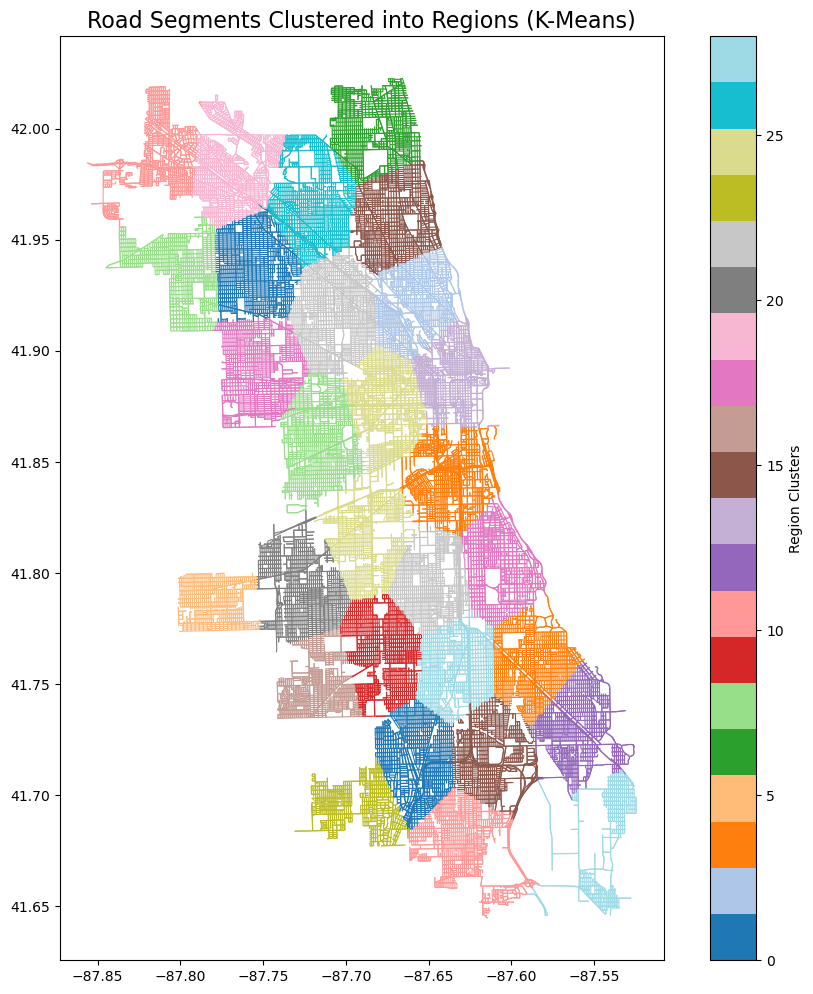

In [22]:
# Plot road segments, colored by their cluster (region)
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, graph=G, ax=ax, color='black', linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)

edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, legend_kwds={'label': "Region Clusters"})

# Add title
plt.title('Road Segments Clustered into Regions (K-Means)', fontsize=16)

shortest_routes_segs_df_group.apply(lambda row: plot_shortest_routes(row), axis=1)


### Check the traffic data from website

In [32]:
chicago_trafficdata=pd.read_csv('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments_20241112.csv')

In [ ]:
len(chicago_trafficdata)

In [ ]:
chicago_trafficdata.head()

In [ ]:
chicago_trafficdata.info()

In [ ]:
#convert the end points of each pair into nodes of the graph:
chicago_trafficdata['start_node']=chicago_trafficdata.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            row['START_LONGITUDE'],
                                                            row[' START_LATITUDE']),
                                                            axis=1)
chicago_trafficdata['end_node']=chicago_trafficdata.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            row['END_LONGITUDE'],
                                                            row[' END_LATITUDE']),
                                                            axis=1)

In [ ]:
chicago_trafficdata.to_csv('chicago_trafficdata_withnodes')

In [100]:
chicago_trafficdata=pd.read_csv('chicago_trafficdata_withnodes')

In [101]:
# Calculate the distance between the point and the nearest node
chicago_trafficdata['start_node_distance'] = chicago_trafficdata.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       row[' START_LATITUDE'],
                                                                       row['START_LONGITUDE'],
                                                                       G.nodes[row['start_node']]['y'], G.nodes[row['start_node']]['x']),
                                                                   axis=1)
chicago_trafficdata['end_node_distance'] = chicago_trafficdata.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       row[' END_LATITUDE'],
                                                                       row['END_LONGITUDE'],
                                                                       G.nodes[row['end_node']]['y'], G.nodes[row['end_node']]['x']),
                                                                   axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\1273812882.py:3: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.distance.great_circle_vec(
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\1273812882.py:9: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.distance.great_circle_vec(


In [ ]:
chicago_trafficdata['start_node_distance'].describe()

In [ ]:
chicago_trafficdata['end_node_distance'].describe()

In [ ]:
len(chicago_trafficdata[(chicago_trafficdata['start_node_distance']<150) &
                  (chicago_trafficdata['end_node_distance']<150)])/len(chicago_trafficdata)

In [102]:
chicago_trafficdata_nodes=chicago_trafficdata[(chicago_trafficdata['start_node_distance']<150) &
                  (chicago_trafficdata['end_node_distance']<150)]

In [36]:
len(chicago_trafficdata_nodes)

1114

In [ ]:
chicago_trafficdata_nodes.columns

In [103]:
chicago_trafficdata_nodes[' LAST_UPDATED']=pd.to_datetime(chicago_trafficdata_nodes[' LAST_UPDATED'])
chicago_trafficdata_nodes[' LAST_UPDATED'].info()

<class 'pandas.core.series.Series'>
Index: 1114 entries, 0 to 1256
Series name:  LAST_UPDATED
Non-Null Count  Dtype         
--------------  -----         
1114 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.4 KB


C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2003770439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes[' LAST_UPDATED']=pd.to_datetime(chicago_trafficdata_nodes[' LAST_UPDATED'])


In [ ]:
len(chicago_trafficdata_nodes[chicago_trafficdata_nodes[' CURRENT_SPEED']==-1])

In [104]:
chicago_trafficdata_nodes['year']=chicago_trafficdata_nodes[' LAST_UPDATED'].apply(lambda x: x.year)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\124908571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes['year']=chicago_trafficdata_nodes[' LAST_UPDATED'].apply(lambda x: x.year)


In [ ]:
chicago_trafficdata_nodes[chicago_trafficdata_nodes[' CURRENT_SPEED']==-1]['year'].value_counts()

In [105]:
# further filter out data with unvalid current_speed and with the last update_time older than this year
mask=(chicago_trafficdata_nodes[' CURRENT_SPEED']==-1) & (chicago_trafficdata_nodes['year']<2024)
chicago_trafficdata_nodes_speed=chicago_trafficdata_nodes[~mask]
len(chicago_trafficdata_nodes_speed)

996

check whether the road segments obtained from the website traffic data have overlap with that in existing chicago dataset.

In [106]:
# calculate the shortest route by length
def get_shortest_route(row):
    try:
        shortest_route=nx.shortest_path(G, row['start_node'], row['end_node'], weight='length')
        shortest_route_length=nx.shortest_path_length(G, row['start_node'], row['end_node'], weight='length')
    except nx.NetworkXNoPath:
        shortest_route=np.nan
        shortest_route_length=np.nan
    return shortest_route, shortest_route_length

In [107]:
# Calculate the shortest route along with its length
chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \
                                                                                             chicago_trafficdata_nodes_speed.apply(
                                                                                                                                 lambda row:
                                                                                                                                pd.Series(get_shortest_route(row)), axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3509817815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3509817815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \


In [108]:
# add a new column about the absolute difference between the actual trip_miles and 
#the calculated shortest route length
chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']=abs(chicago_trafficdata_nodes_speed['LENGTH']
                                                                  *1609.344-chicago_trafficdata_nodes_speed['shortest_route_length'])

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3540466914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']=abs(chicago_trafficdata_nodes_speed['LENGTH']


In [ ]:
chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters'].describe()

In [109]:
chicago_trafficdata_nodes_speed_routes=chicago_trafficdata_nodes_speed[
    chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']<500]

In [ ]:
chicago_trafficdata_nodes_speed_routes['shortest_route'].values[0]

In [ ]:
data_merged_routes_diff500_chopped['shortest_route'].values[0]

In [110]:
chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]]=chicago_trafficdata_nodes_speed_routes.apply(lambda row:
                                                                                                                          pd.Series(extract_road_segments_details(row)),
                                                                                                                          axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\4163048201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec',
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\4163048201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec',


In [ ]:
chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]].head()

In [ ]:
chicago_trafficdata_nodes_speed_routes[
                                                               'edge_data_ls' 
                                                              ].values[0]

In [ ]:
len(chicago_trafficdata_nodes_speed_routes)

In [111]:
# combine all segments into a list
chicago_trafficdata_shortest_segs_ls=[]
for x in chicago_trafficdata_nodes_speed_routes['edge_data_ls'].values:
    chicago_trafficdata_shortest_segs_ls.extend(x)
len(chicago_trafficdata_shortest_segs_ls)

6882

In [ ]:
len(shortest_routes_segs_df_group)

In [112]:
chicago_trafficdata_shortest_segs_df=pd.DataFrame(chicago_trafficdata_shortest_segs_ls)
# remove list object 
chicago_trafficdata_shortest_segs_df=chicago_trafficdata_shortest_segs_df.apply(remove_list_obj)
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df.drop_duplicates()
len(chicago_trafficdata_shortest_segs_df_group)

6848

In [ ]:
chicago_trafficdata_shortest_segs_df_group.head()

In [ ]:
# Plot road segments in both datasets
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, color, ax=ax, linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)
shortest_routes_segs_df_group.apply(plot_shortest_routes, color='black', axis=1)
chicago_trafficdata_shortest_segs_df_group.apply(plot_shortest_routes, color='red',
                                                 axis=1)

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group.columns)

In [ ]:
chicago_trafficdata_shortest_segs_df_group.columns

In [ ]:
len(shortest_routes_segs_df_group.columns)

In [ ]:
shortest_routes_segs_df_group.columns

In [113]:
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df_group.reindex(shortest_routes_segs_df_group.columns, axis=1)

In [ ]:
chicago_trafficdata_shortest_segs_df_group['area'].isnull().sum()

In [ ]:
len(shortest_routes_segs_df_group)

In [ ]:
shortest_routes_segs_df_group['area'].isnull().sum()

In [114]:
segs_merge=pd.concat([shortest_routes_segs_df_group, chicago_trafficdata_shortest_segs_df_group],
                     ignore_index=False)

In [49]:
len(segs_merge)==len(shortest_routes_segs_df_group)+len(chicago_trafficdata_shortest_segs_df_group)

True

In [115]:
# redundent segments that already existed
segs_merge.duplicated().sum()/len(chicago_trafficdata_shortest_segs_df_group)

0.9028913551401869

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group)

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group)-segs_merge.duplicated().sum()

In [116]:
# Identify common rows using isin and all columns
mask = chicago_trafficdata_shortest_segs_df_group.isin(
    shortest_routes_segs_df_group.to_dict(orient='list')
).all(axis=1)

# Keep rows not in common
filtered_chicago_trafficdata_shortest_segs_df_group = chicago_trafficdata_shortest_segs_df_group[~mask]
len(filtered_chicago_trafficdata_shortest_segs_df_group)


665

In [ ]:
# Plot road segments, colored by their cluster (region)
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, color, ax=ax, linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)


shortest_routes_segs_df_group.apply(plot_shortest_routes, color='black', axis=1)
filtered_chicago_trafficdata_shortest_segs_df_group.apply(plot_shortest_routes, color='red',
                                                 axis=1)

### Check the road segment types

In [ ]:
edges.head()

In [ ]:
edges.columns

- The 'reversed' column in the edges GeoDataFrame typically indicates whether the direction of a road segment (edge) has been reversed relative to its default representation in the road network.
- 'bridge' represents whether a segment is a bridge. True or yes means it is a bridge, otherwise, being false or NaN means it is not a bridge.
- 'ref' contains reference identifiers for the segment.
- 'tunnel' represents whether a road segment is a tunnel. NaN means the edge is not a tunnel.
- 'access' describes access restrictions. If yes or NaN means no restrictions.
- 'junction' means whether a road is a part of a junction/intersection. NaN means the edge is not part of a junction.

To group edges based on their similarity for learning traffic patterns and performing route optimization, we should choose columns that are the most relevant attributes affecting traffic:
- region: Represents spatial clustering. Useful for capturing regional traffic behavior differences.
- highway: Traffic behavior differs significantly by road type.
- lanes: The number of lanes directly affects traffic capacity and congestion levels.
- speed_kph: Speed limits are crucial for understanding expected travel times and traffic flow.
- access: Indicates access restrictions, which could affect traffic density (e.g., private, permissive).
- junction: Important for identifying special road segments like roundabouts or complex intersections where traffic behavior differs.
- bridge and tunnel: These attributes often indicate constrained segments where traffic might behave differently due to structural limitations.

In [ ]:
edges['highway'].value_counts().index

- secondary:  medium sized roads that connect smaller towns or districts. less traffic than primary but more than tertiary.
- tertiary: smaller roads that connect villages or neighborhoods. moderate traffic.
- primary: major roads connect larger towns or cities. significant traffic flow but less than motorway and trunks.
- motorway_link: short connecting roads between motorways and other types of roads. Often used to enter or leave a motorway.
- motorway: high speed roads with limited access. Designed for long-distance and high-volume traffic.
- trunk: major roads, connecting cities or regions, but not motorway. Important for long-distance travel.
- emergency_bay: dedicated areas on motorway for emergency.
- living_street: roads primarily for pedestrain traffic, with restricted vehical access and with very low speed limit.
- ['residential', 'tertiary']: Could indicate a road that transitions between residential and tertiary classifications.

In [117]:
# remove list object for the following operation
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df_group.apply(remove_list_obj)
segs_merge_uni=segs_merge.drop_duplicates()
segs_merge_uni=segs_merge_uni.apply(remove_list_obj)

In [118]:
grouping_columns = ['region', 'highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel']
edge_groups = edges.groupby(grouping_columns)
shortest_routes_edge_groups=shortest_routes_segs_df_group.groupby(grouping_columns)
chicago_trafficdata_shortest_edge_groups=chicago_trafficdata_shortest_segs_df_group.groupby(grouping_columns)
shortest_merge_edge_groups=segs_merge_uni.groupby(grouping_columns)

In [119]:
len(list(edge_groups))

1318

In [120]:
len(list(shortest_routes_edge_groups))

1082

In [121]:
len(list(chicago_trafficdata_shortest_edge_groups))

460

In [122]:
len(list(shortest_merge_edge_groups))

1109

In [123]:
1082/1318

0.8209408194233687

In [58]:
1406/1698

0.8280329799764429

In [ ]:
1437/1703

In [ ]:
edges['region'].value_counts().plot(kind='bar')

In [129]:
num_regions=15
num_seg_types={}
for i in range(num_regions):
    num_seg_types[f'region {i}']=len(list(edges[edges['region']==i].groupby(['highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [130]:
shortest_routes_num_seg_types={}
for i in range(num_regions):
    shortest_routes_num_seg_types[f'region {i}']=len(list(shortest_routes_segs_df_group[shortest_routes_segs_df_group['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [131]:
chicago_trafficdata_shortest_num_seg_types={}
for i in range(num_regions):
    chicago_trafficdata_shortest_num_seg_types[f'region {i}']=len(list(chicago_trafficdata_shortest_segs_df_group
                                                                       [chicago_trafficdata_shortest_segs_df_group['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [132]:
shortest_merge_num_seg_types={}
for i in range(num_regions):
    shortest_merge_num_seg_types[f'region {i}']=len(list(segs_merge_uni[segs_merge_uni['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [133]:
edge_types_comp=pd.DataFrame({'all_edge_types': num_seg_types, 
                              'shortest_routes_edge_types': shortest_routes_num_seg_types,
                              'chicago_trafficdata_shortest_edge_types': chicago_trafficdata_shortest_num_seg_types,
                             'shortest_merge_edge_types': shortest_merge_num_seg_types})
edge_types_comp['ratio']=edge_types_comp['shortest_routes_edge_types']/edge_types_comp['all_edge_types']
edge_types_comp['ratio_merge']=edge_types_comp['shortest_merge_edge_types']/edge_types_comp['all_edge_types']
edge_types_comp

all_edge_types  shortest_routes_edge_types  \
region 0               34                          22   
region 1               70                          54   
region 2              115                          97   
region 3              107                         102   
region 4               58                          33   
region 5               95                          87   
region 6              108                          99   
region 7               87                          75   
region 8               72                          52   
region 9               89                          61   
region 10              55                          49   
region 11              33                          25   
region 12              72                          60   
region 13             236                         188   
region 14              87                          78   

           chicago_trafficdata_shortest_edge_types  shortest_merge_edge_types  \
region 0                                        11                         22   
region 1                                        24                         57   
region 2                                        29                         98   
region 3                                        38                        102   
region 4                                        26                         39   
region 5                                        29                         87   
region 6                                        26                         99   
region 7                                        33                         76   
region 8                                        20                         52   
region 9                                        28                         68   
region 10                                       19                         49   
region 11                                       20                         27   
region 12                                       27                         60   
region 13                                      100                        191   
region 14                                       30                         82   

              ratio  ratio_merge  
region 0   0.647059     0.647059  
region 1   0.771429     0.814286  
region 2   0.843478     0.852174  
region 3   0.953271     0.953271  
region 4   0.568966     0.672414  
region 5   0.915789     0.915789  
region 6   0.916667     0.916667  
region 7   0.862069     0.873563  
region 8   0.722222     0.722222  
region 9   0.685393     0.764045  
region 10  0.890909     0.890909  
region 11  0.757576     0.818182  
region 12  0.833333     0.833333  
region 13  0.796610     0.809322  
region 14  0.896552     0.942529

In [64]:
edge_types_comp_29clusters=edge_types_comp

In [ ]:
edges[edges['region']==5].groupby(['highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [ ]:
shortest_routes_segs_df_group[shortest_routes_segs_df_group['region']==20].groupby(['highway', 
                                                                                   'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [ ]:
chicago_trafficdata_shortest_segs_df_group[chicago_trafficdata_shortest_segs_df_group['region']==5].groupby(['highway', 
                                                                                   'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [134]:
ls1=edge_types_comp['ratio'].to_list()
ls_r1=[round(x, 2) for x in ls1]
ls2=edge_types_comp['ratio_merge'].to_list()
ls_r2=[round(x, 2) for x in ls2]

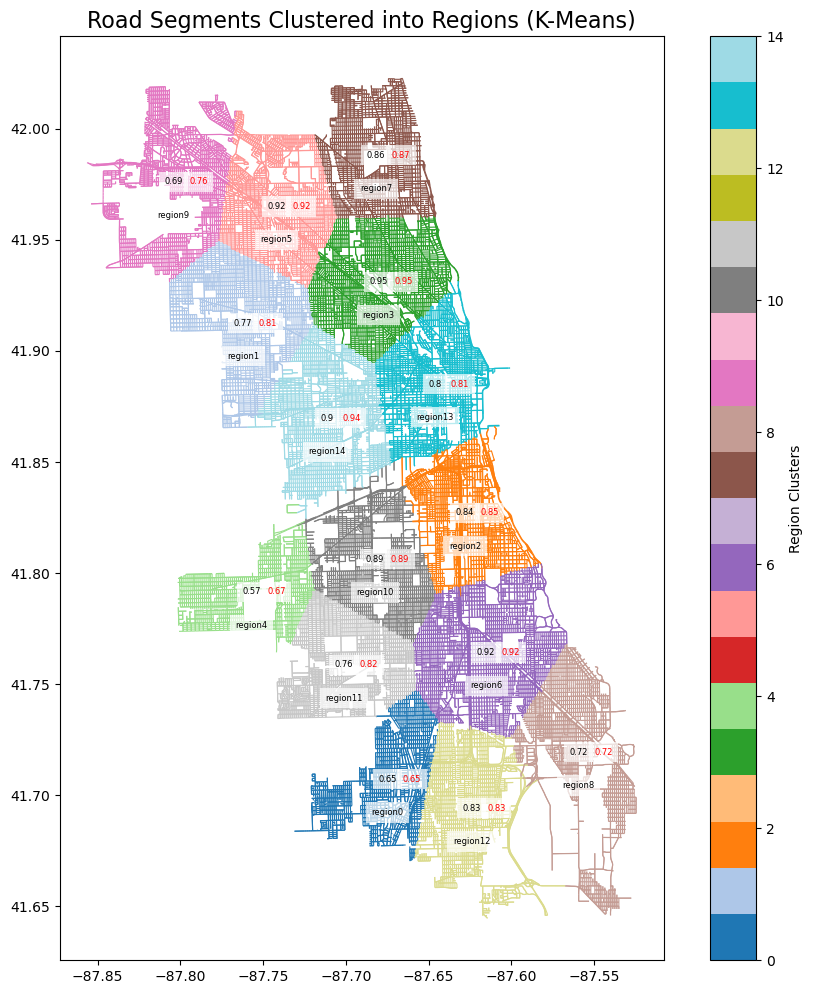

In [135]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot edges with clustering
edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, legend_kwds={'label': "Region Clusters"})

# Calculate and plot region labels
region_centroids = edges.groupby('region')['geometry'].apply(lambda x: x.unary_union.centroid)

for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y-0.015, f'region{region}',  # Adjust position slightly
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


# First set of numbers (from edge_types_comp['ratio'])
for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y, str(ls_r1[region]), 
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Second set of numbers (from edge_types_comp['ratio_merge'])

for region, centroid in region_centroids.items():
    ax.text(centroid.x + 0.015, centroid.y, str(ls_r2[region]),  # Adjust position slightly
            fontsize=6, ha='center', va='center', color='red', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add title
plt.title('Road Segments Clustered into Regions (K-Means)', fontsize=16)

plt.show()


### convert the existing trip level dataset into road segment level dataset

In [ ]:
data_merged_routes_diff500.columns

In [ ]:
len(data_merged_routes_diff500)

In [ ]:
# add the 'free_travel_time_total_sec' and 'edge_data_ls' columns to the original trip level dataset
data_merged_routes_diff500_chopped_subcols=data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 'shortest_route']]
trips_segs_merge=pd.merge(data_merged_routes_diff500, data_merged_routes_diff500_chopped_subcols, on='shortest_route')

In [ ]:
trips_segs_merge.head()

In [ ]:
len(trips_segs_merge)

#####  Distribute Trip Travel Time to Segments
Since trip-level data provides total travel time, we can estimate segment-level travel times by distributing the trip-level travel time across the matched road segments propotionally based on their free flow information. Specifically, based on the given speed limit and length, calculate the free-flow travel time ratio of each segment over the whole route, and then multiply this ratio to the actual total trip time to infer the actual travel time for each segment.

In [ ]:
X=pd.DataFrame(trips_segs_merge[ 'edge_data_ls'][0])
X.head()

In [ ]:
X.columns

In [ ]:
X['free_flow_time_ratio']=X['travel_time']/X['travel_time'].sum()

In [ ]:
X.head()

In [ ]:
X['inferred_travel_time_sec']=X['free_flow_time_ratio']*trips_segs_merge['trip_seconds'].values[0]

In [ ]:
X.head()

In [ ]:
X['inferred_travel_time_sec'].sum()

In [ ]:
trips_segs_merge['trip_seconds'].values[0]

In [ ]:
X[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]=trips_segs_merge[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']].values[0]

In [ ]:
X.columns

In [ ]:
X.head()

##### Note that the following cell cant be run in notebook since it will cause page snapped. You need to run another copy of py script in anaconda prompt.

In [ ]:
# the following code can be run in notebook since it will cause page snapped. Need to run it in Anaconda prompt
def create_seg_level_df (row):
    total_free_travel_time=row['free_travel_time_total_sec']
    X=pd.DataFrame(row['edge_data_ls'])[[ 'lanes',  'highway', 
        'speed_kph', 'travel_time', 'region',  'u', 'v', 'junction',
       'bridge', 'tunnel', 'access']]
    X['inferred_travel_time_sec']=X['travel_time']/total_free_travel_time*row['trip_seconds']
    X[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]=row[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]
    return X
chunk_size = 100  # Adjust based on available memory

# Open the file in append mode and write chunks incrementally
for i in range(0, len(trips_segs_merge), chunk_size):
    chunk = trips_segs_merge.iloc[i:i + chunk_size]
    chunk_result = pd.concat(chunk.apply(create_seg_level_df, axis=1).to_list(), ignore_index=True)
    
    # Write chunk results to file
    chunk_result.to_csv('segment_level_data.csv', mode='a', index=False, header=(i == 0));  

### EDA on segment level

In [160]:
!pip install statsmodels

In [136]:
!pip install dask

In [2]:
import dask.dataframe as dd
from statsmodels.tsa.seasonal import seasonal_decompose
import gc

In [ ]:
# Load the CSV lazily with Dask
ddf = dd.read_csv('segment_level_data.csv')

In [3]:
for region in range(29):
    print(region)
    filtered_region = ddf[ddf['region'] == region]
    
    # Save the filtered data directly to a file
    filtered_region.to_csv(f'filtered_region_{region}.csv', single_file=True, index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [11]:
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['week_of_year'] = data_merged_routes_diff500['trip_start_timestamp'].dt.isocalendar().week
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour
total_yearly=data_merged_routes_diff500['year'].value_counts(normalize=True).sort_index()
yearly_comp=pd.DataFrame({'total_yearly': total_yearly})
total_monthly=data_merged_routes_diff500['month'].value_counts(normalize=True).sort_index()
monthly_comp=pd.DataFrame({'total_monthly': total_monthly})
total_daily=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 
                                                                                        'Friday', 'Saturday', 'Sunday'], axis=1)
daily_comp=pd.DataFrame({'total_daily': total_daily})
total_hourly=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
hourly_comp=pd.DataFrame({'total_hourly': total_hourly})

In [5]:
pd.read_csv('filtered_region_0.csv').columns

Index(['lanes', 'highway', 'speed_kph', 'travel_time', 'region', 'u', 'v',
       'junction', 'bridge', 'tunnel', 'access', 'inferred_travel_time_sec',
       'Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres'],
      dtype='object')

In [12]:
# Loop through each region
for region in range(29):
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    
    # temporal pattern comparison
    region_yearly=filtered_region['year'].value_counts(normalize=True).sort_index()
    yearly_comp[f'region_{region}_yearly']=region_yearly
    region_monthly=filtered_region['month'].value_counts(normalize=True).sort_index()
    monthly_comp[f'region_{region}_monthly']=region_monthly
    region_daily=filtered_region['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 
                                                                                  'Friday', 'Saturday', 'Sunday'], axis=1)
    daily_comp[f'region_{region}_daily']=region_daily
    region_hourly=filtered_region['hour_start'].value_counts(normalize=True).sort_index()
    hourly_comp[f'region_{region}_hourly']=region_hourly 
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

Processed and cleared region 0
Processed and cleared region 1
Processed and cleared region 2
Processed and cleared region 3
Processed and cleared region 4
Processed and cleared region 5
Processed and cleared region 6
Processed and cleared region 7
Processed and cleared region 8
Processed and cleared region 9
Processed and cleared region 10
Processed and cleared region 11
Processed and cleared region 12
Processed and cleared region 13
Processed and cleared region 14
Processed and cleared region 15
Processed and cleared region 16
Processed and cleared region 17
Processed and cleared region 18
Processed and cleared region 19
Processed and cleared region 20
Processed and cleared region 21
Processed and cleared region 22
Processed and cleared region 23
Processed and cleared region 24
Processed and cleared region 25
Processed and cleared region 26
Processed and cleared region 27
Processed and cleared region 28


In [168]:
monthly_comp

total_monthly  region_0_monthly  region_1_monthly  region_2_monthly  \
month                                                                        
1           0.083293          0.085275          0.082476          0.078542   
2           0.082718          0.090550          0.085187          0.078554   
3           0.094069          0.100881          0.094998          0.093442   
4           0.083988          0.085140          0.086349          0.082390   
5           0.078568          0.082365          0.076758          0.078470   
6           0.078643          0.076270          0.075248          0.082087   
7           0.081800          0.074801          0.073591          0.087399   
8           0.080486          0.077867          0.080547          0.084973   
9           0.080949          0.076057          0.081471          0.083919   
10          0.086869          0.075490          0.085603          0.084754   
11          0.079848          0.089959          0.085891          0.075790   
12          0.088769          0.085345          0.091880          0.089681   

       region_3_monthly  region_4_monthly  region_5_monthly  region_6_monthly  \
month                                                                           
1              0.085328          0.074556          0.075875          0.089998   
2              0.094047          0.078162          0.073489          0.084492   
3              0.102808          0.089017          0.089924          0.093350   
4              0.088385          0.086975          0.079071          0.090173   
5              0.078579          0.085352          0.084061          0.077361   
6              0.071432          0.086658          0.086618          0.077962   
7              0.075329          0.087130          0.092887          0.075914   
8              0.078683          0.081727          0.081566          0.079512   
9              0.073381          0.084168          0.085090          0.078755   
10             0.078855          0.087970          0.088708          0.085713   
11             0.080238          0.081948          0.082190          0.079233   
12             0.092935          0.076337          0.080521          0.087537   

       region_7_monthly  region_8_monthly  ...  region_19_monthly  \
month                                      ...                      
1              0.080441          0.085600  ...           0.078002   
2              0.080184          0.091416  ...           0.080808   
3              0.097113          0.095253  ...           0.095286   
4              0.089844          0.088255  ...           0.086346   
5              0.076059          0.078534  ...           0.075226   
6              0.083261          0.072796  ...           0.080322   
7              0.076326          0.075604  ...           0.081902   
8              0.073125          0.080781  ...           0.086893   
9              0.082308          0.085824  ...           0.076697   
10             0.095855          0.077202  ...           0.082265   
11             0.084309          0.082395  ...           0.086131   
12             0.081175          0.086339  ...           0.090122   

       region_20_monthly  region_21_monthly  region_22_monthly  \
month                                                            
1               0.079936           0.080420           0.080819   
2               0.076129           0.084381           0.094594   
3               0.089211           0.094466           0.100393   
4               0.086841           0.082519           0.091638   
5               0.079035           0.077556           0.077415   
6               0.080681           0.077455           0.070747   
7               0.085647           0.082393           0.076127   
8               0.086793           0.079228           0.077690   
9               0.083921           0.083984           0.081773   
10              0.086561           0.087231           0.082833   
11              0.08

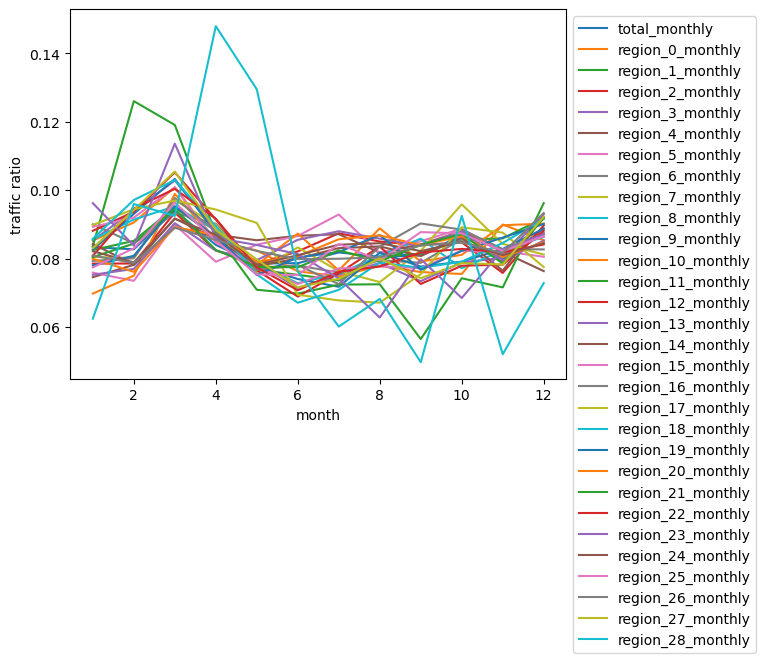

In [13]:
monthly_comp.plot(kind='line')
plt.ylabel('traffic ratio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position legend outside the plot

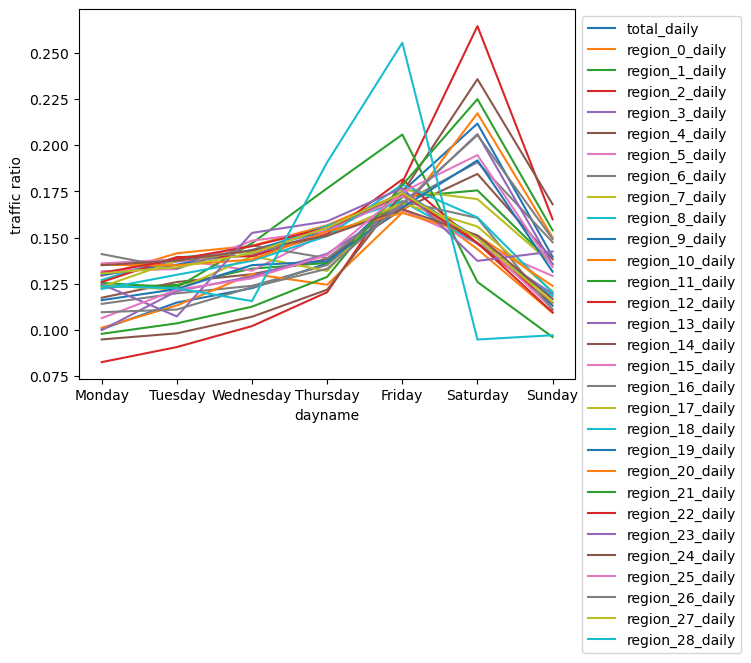

In [14]:
daily_comp.plot(kind='line')
plt.ylabel('traffic ratio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

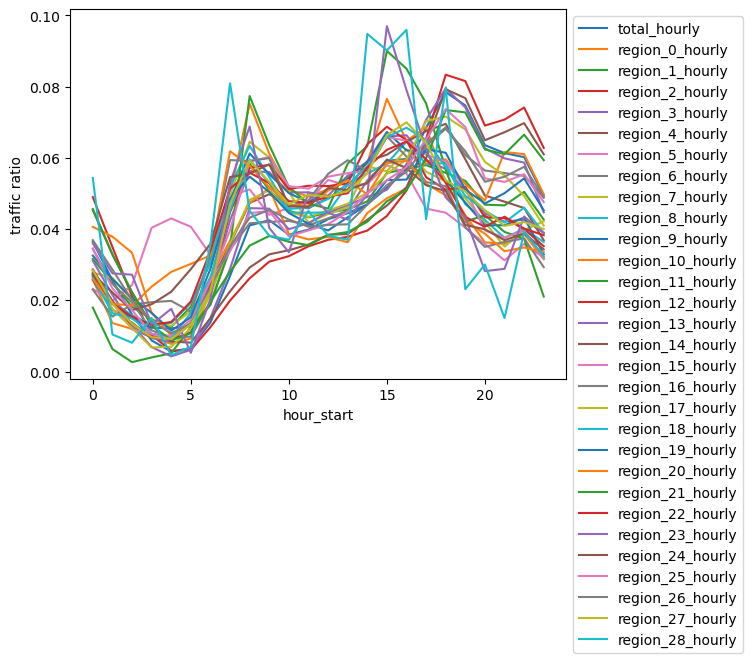

In [15]:
hourly_comp.plot(kind='line')
plt.ylabel('traffic ratio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

##### road segments clustering within each region

##### first cluster segments by some inherent road characteristics

In [173]:
# Loop through each region
regions_c1_timeframe={}
regions_c1_hourly={}
regions_inferred_traveltime_hourly={}
regions_traveltime_hourly={}
for region in range(29):
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], filtered_region['travel_time'])
    region_inferred_traveltime_hourly=filtered_region.groupby('hour_start')['inferred_travel_time_sec'].mean()
    region_traveltime_hourly=filtered_region.groupby('hour_start')['travel_time'].mean()
    regions_inferred_traveltime_hourly[f'region_{region}_inferred_traveltime_hourly']=region_inferred_traveltime_hourly 
    regions_traveltime_hourly[f'region_{region}_traveltime_hourly']=region_traveltime_hourly 
    # add a new column 'morning_afternoon_night' to group hours of day to morning, afternoon, and night time frames 
    filtered_region['morning_afternoon_night'] = filtered_region['hour_start'].apply(
    lambda x: 'morning' if 6 <= x < 12 
              else 'afternoon' if 12 <= x <18 
              else 'night' )
    
    filtered_region_c1_timeframe=filtered_region.groupby(
    ['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access', 'morning_afternoon_night']
    )['inferred_travel_time_sec'].mean().unstack().reindex(['morning', 'afternoon', 'night'], axis=1)
    regions_c1_timeframe[f'filtered_region_{region}_c1_timeframe']=filtered_region_c1_timeframe
    filtered_region_c1_hourly=filtered_region.groupby(
    ['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access', 'hour_start']
    )['inferred_travel_time_sec'].mean().unstack()
    regions_c1_hourly[f'filtered_region_{region}_c1_hourly']=filtered_region_c1_hourly
    
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

Processed and cleared region 0
Processed and cleared region 1
Processed and cleared region 2
Processed and cleared region 3
Processed and cleared region 4
Processed and cleared region 5
Processed and cleared region 6
Processed and cleared region 7
Processed and cleared region 8
Processed and cleared region 9
Processed and cleared region 10
Processed and cleared region 11
Processed and cleared region 12
Processed and cleared region 13
Processed and cleared region 14
Processed and cleared region 15
Processed and cleared region 16
Processed and cleared region 17
Processed and cleared region 18
Processed and cleared region 19
Processed and cleared region 20
Processed and cleared region 21
Processed and cleared region 22
Processed and cleared region 23
Processed and cleared region 24
Processed and cleared region 25
Processed and cleared region 26
Processed and cleared region 27
Processed and cleared region 28


In [210]:
# Function to fill NaN values in hourly traffic distribution: to fill each hourly missing data by the corresponding morning or afternoon or night average traffic data for the same 
# road segment type, if the morning or afternoon or night average traffic data is also missing, fill it by using the average over the existing other 
# timeframe average.
morning_hours=[6,7,8,9,10,11]
afternoon_hours=[12,13,14,15,16,17]
night_hours=[18,19,20,21,22,23,0,1,2,3,4,5]
def fill_na(row):
    for hour_col in range(24):
        if pd.isna(row[hour_col]):
            if hour_col in morning_hours:
                if not pd.isna(row['morning']):
                    row[hour_col]=row['morning']
                else:
                    row[hour_col]=np.nanmean([row['afternoon'], row['night']])
            elif hour_col in afternoon_hours:
                if not pd.isna(row['afternoon']):
                    row[hour_col]=row['afternoon']
                else:
                    row[hour_col]=np.nanmean([row['morning'], row['night']])
            else:
                if not pd.isna(row['night']):
                    row[hour_col]=row['night']
                else:
                    row[hour_col]=np.nanmean([row['morning'], row['afternoon']])
    return row

In [211]:
#application
regions_c1_hourly_fillna={}
for region in range(29):
    filtered_region_merge=pd.merge(regions_c1_hourly[f'filtered_region_{region}_c1_hourly'],
                                              regions_c1_timeframe[f'filtered_region_{region}_c1_timeframe'], left_index=True, right_index=True)
    regions_c1_hourly_fillna[f'filtered_region_{region}_c1_hourly_fillna']=filtered_region_merge.apply(fill_na, axis=1).loc[:, :23]    

##### use elbow method to determine K

In [222]:
!pip install scikit-plot

In [178]:
from sklearn.cluster import KMeans 
from scikitplot.cluster import plot_elbow_curve

In [1437]:
region=6
X=regions_c1_hourly_fillna[f'filtered_region_{region}_c1_hourly_fillna']

In [1438]:
# Extract hourly travel time data
hourly_data = X.values

# Normalize each road type by its total travel time to capture patterns
pattern_data = hourly_data / np.sum(hourly_data, axis=1, keepdims=True)

# Add the sum (scale) back as a feature
scale_feature = np.sum(hourly_data, axis=1).reshape(-1, 1)

# Combine pattern and scale features
combined_features = np.hstack((pattern_data, scale_feature))

C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

<Axes: title={'center': 'Elbow Plot'}, xlabel='Number of clusters', ylabel='Sum of Squared Errors'>

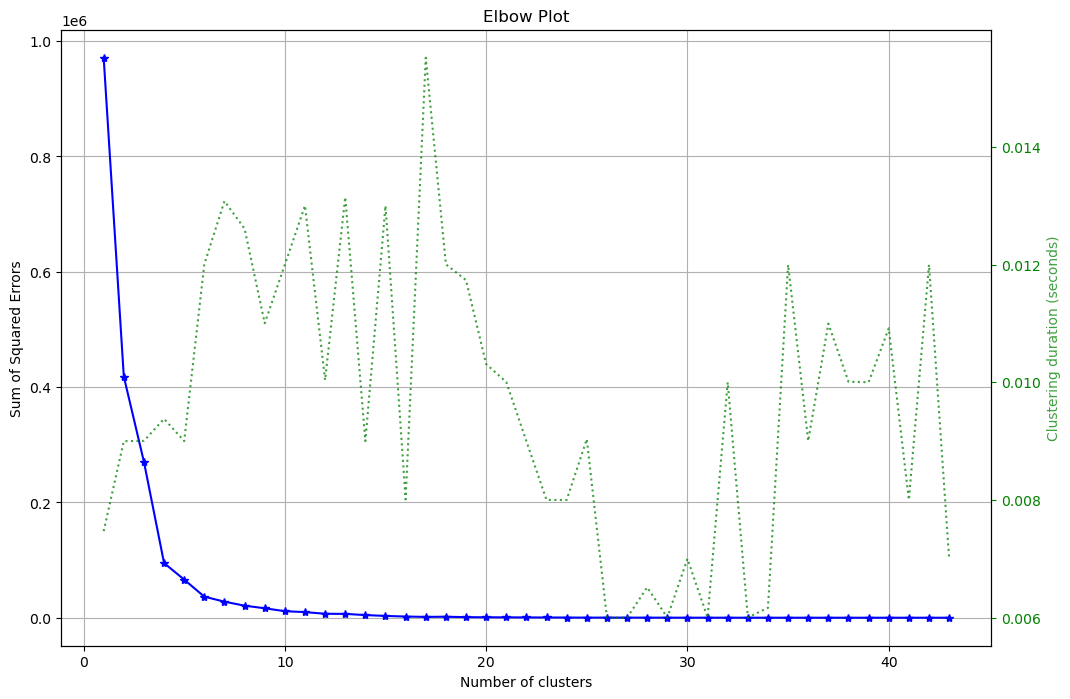

In [1439]:
#### plot the elbow plot
model = KMeans()
plot_elbow_curve(model, combined_features, cluster_ranges=range(1, len(X)), figsize=(12, 8))

In [1440]:
kmeans = KMeans(n_clusters=7, random_state=42) 
X['cluster']=kmeans.fit_predict(combined_features) 

C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [1441]:
X['cluster'].value_counts()

cluster
0    13
3    10
6     8
4     8
2     3
5     1
1     1
Name: count, dtype: int64

In [1428]:
X[X['cluster']==2]

0  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     31.214286   
secondary   43.8      2.0   no       no     no     yes     34.600000   
                      3.0   no       no     no     yes     19.872046   
                      4.0   no       no     no     yes     16.800000   
                      4.5   no       no     no     yes     30.350000   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   1  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     27.258862   
secondary   43.8      2.0   no       no     no     yes     32.096767   
                      3.0   no       no     no     yes     21.761741   
                      4.0   no       no     no     yes     33.862960   
                      4.5   no       no     no     yes     36.309101   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   2  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     27.258862   
secondary   43.8      2.0   no       no     no     yes     32.096767   
                      3.0   no       no     no     yes     20.363096   
                      4.0   no       no     no     yes     33.862960   
                      4.5   no       no     no     yes     36.309101   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   3  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     27.258862   
secondary   43.8      2.0   no       no     no     yes     32.096767   
                      3.0   no       no     no     yes     18.144691   
                      4.0   no       no     no     yes     33.862960   
                      4.5   no       no     no     yes     36.309101   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   4  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     27.258862   
secondary   43.8      2.0   no       no     no     yes     32.096767   
                      3.0   no       no     no     yes     20.534578   
                      4.0   no       no     no     yes     33.862960   
                      4.5   no       no     no     yes     36.309101   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   5  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     27.258862   
secondary   43.8      2.0   no       no     no     yes     32.096767   
                      3.0   no       no     no     yes     19.930596   
                      4.0   no       no     no     yes     33.862960   
                      4.5   no       no     no     yes     36.309101   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                                                                   6  \
highway     speed_kph lanes junction bridge tunnel access              
residential 31.9      2.0   no       no     no     yes     26.521048   
secondary   43.8      2.0   no       no     no     yes     28.100000   
                      3.0   no       no     no     yes     19.470766   
                      4.0   no       no     no     yes     33.112500   
                      4.5   no       no     no     yes     37.200000   
tertiary    41.6      2.0   no       no     no     yes     38.525000   

                            

In [1442]:
# Clear memory by deleting the current region's dataframe
del filtered_region
del merge
# Force garbage collection
gc.collect()

NameError: name 'filtered_region' is not defined

In [1443]:
filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
filtered_region['week_of_year'] = filtered_region['trip_start_timestamp'].dt.isocalendar().week
filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], filtered_region['travel_time'])
filtered_region=filtered_region.set_index(['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access'])

In [1444]:
merge=pd.merge(filtered_region, X[['cluster']], left_index=True, right_index=True)
merge['cluster'].value_counts()

cluster
3    312187
2    246877
4    234702
0    165523
6     22606
1      2521
5      1570
Name: count, dtype: int64

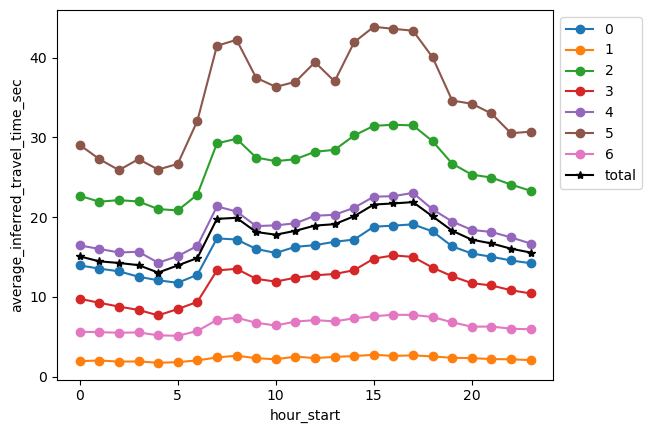

In [1445]:
time='hour_start'
df_plt=merge.groupby(['cluster', time])['inferred_travel_time_sec'].mean().unstack().T
df_plt['total']=merge.groupby(time)['inferred_travel_time_sec'].mean()
df_plt.iloc[:,:-1].plot(marker='o')
df_plt['total'].plot(marker='*', color='black', label='total')
plt.ylabel('average_inferred_travel_time_sec')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

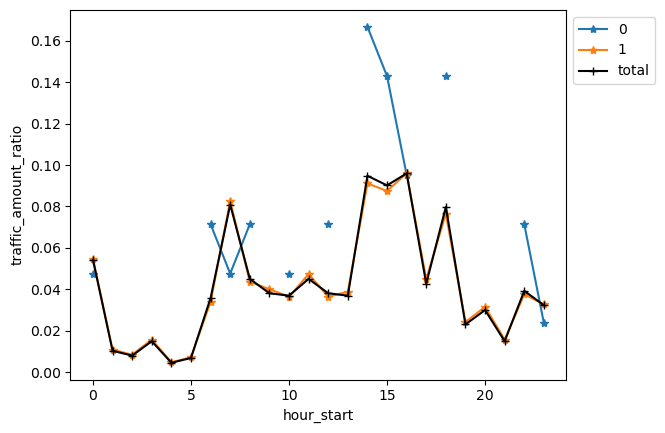

In [1422]:
df_plt2=merge.groupby('cluster')[time].value_counts(normalize=True).unstack().T
df_plt2['total']=merge[time].value_counts(normalize=True)
df_plt2.iloc[:,:-1].plot(marker='*')
df_plt2['total'].plot(marker='+', color='black', label='total')
plt.ylabel('traffic_amount_ratio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

Analysis: based on checking the clustering result for each of 29 regions one by one, I got the following result which works best that has a good trade off between keeping the granularity and merging the outliers. 

---

###### Region 0: 5 Clusters
- Cluster 1: 136,139  rows
- Cluster 3: 87,321  
- Cluster 4: 11,979  
- Cluster 2: 7,221  
- Cluster 0: 974  

---

###### Region 1: 4 Clusters
- Cluster 3: 274,029  
- Cluster 0: 250,308  
- Cluster 2: 132,282  
- Cluster 1: 1,393  

---

###### Region 2: 7 Clusters
- Cluster 0: 3,636,148  
- Cluster 4: 3,314,306  
- Cluster 5: 87,455  
- Cluster 3: 57,613  
- Cluster 1: 28,470  
- Cluster 2: 25,745  
- Cluster 6: 3,628  

---

###### Region 3: 7 Clusters
- Cluster 6: 414,969  
- Cluster 3: 365,949  
- Cluster 5: 59,370  
- Cluster 2: 7,497  
- Cluster 1: 6,867  
- Cluster 0: 5,113  
- Cluster 4: 1,726  

---

###### Region 4: 6 Clusters
- Cluster 0: 717,139  
- Cluster 2: 645,607  
- Cluster 4: 169,465  
- Cluster 5: 16,388  
- Cluster 1: 8,880  
- Cluster 3: 5,350  

---

###### Region 5: 4 Clusters
- Cluster 1: 42,072  
- Cluster 0: 18,819  
- Cluster 3: 2,404  
- Cluster 2: 837  

---

###### Region 6: 7 Clusters
- Cluster 3: 312,542  
- Cluster 2: 246,877  
- Cluster 4: 234,702  
- Cluster 0: 165,168  
- Cluster 6: 22,606  
- Cluster 1: 2,521  
- Cluster 5: 1,570  

---

###### Region 7: 5 Clusters
- Cluster 4: 52,630  
- Cluster 0: 21,846  
- Cluster 3: 20,671  
- Cluster 2: 9,791  
- Cluster 1: **<span style="color:red;">33</span>**  

---

###### Region 8: 8 Clusters
- Cluster 3: 409,623  
- Cluster 5: 171,706  
- Cluster 7: 82,123  
- Cluster 6: 21,662  
- Cluster 4: 21,015  
- Cluster 1: 13,040  
- Cluster 0: 9,927  
- Cluster 2: 2,013  

---

###### Region 9: 6 Clusters
- Cluster 4: 135,332  
- Cluster 5: 126,617  
- Cluster 1: 61,768  
- Cluster 0: 41,116  
- Cluster 3: 4,760  
- Cluster 2:  **<span style="color:red;">379</span>**    

---

###### Region 10: 5 Clusters
- Cluster 4: 36,172  
- Cluster 0: 23,742  
- Cluster 3: 21,909  
- Cluster 1: 3,088  
- Cluster 2: 1,120  

---

###### Region 11: 4 Clusters
- Cluster 3: 39,099  
- Cluster 0: 13,627  
- Cluster 2: 953  
- Cluster 1: **<span style="color:red;">102</span>**  

---

###### Region 12: 4 Clusters
- Cluster 0: 201,792  
- Cluster 2: 1,287  
- Cluster 1: **<span style="color:red;">312</span>**    
- Cluster 3: **<span style="color:red;">3</span>**   

---

###### Region 13: 7 Clusters
- Cluster 6: 10,988,725  
- Cluster 2: 899,345  
- Cluster 0: 805,271  
- Cluster 4: 173,738  
- Cluster 1: 105,473  
- Cluster 3: 38,488  
- Cluster 5: **<span style="color:red;">79</span>**  

---

###### Region 14: 9 Clusters
- Cluster 1: 1,299,771  
- Cluster 4: 928,698  
- Cluster 0: 739,564  
- Cluster 7: 127,936  
- Cluster 5: 104,097  
- Cluster 2: 37,446  
- Cluster 8: 22,280  
- Cluster 3: 7,107  
- Cluster 6: **<span style="color:red;">232</span>**  

---

###### Region 15: 5 Clusters
- Cluster 0: 134,245  
- Cluster 4: 130,982  
- Cluster 2: 15,375  
- Cluster 1: 3,682  
- Cluster 3: 1,369  

---

###### Region 16: 5 Clusters
- Cluster 1: 64,944  
- Cluster 4: 5,320  
- Cluster 2: 1,258  
- Cluster 0: 1,069  
- Cluster 3: **<span style="color:red;">247</span>**  

---

###### Region 17: 6 Clusters
- Cluster 4: 674,796  
- Cluster 0: 607,723  
- Cluster 3: 85,054  
- Cluster 1: 5,316  
- Cluster 2: 5,029  
- Cluster 5: 2,396  

---

###### Region 18: 4 Clusters
- Cluster 3: 222,165  
- Cluster 1: 165,955  
- Cluster 0: 41,170  
- Cluster 2: **<span style="color:red;">236</span>**  

---

###### Region 19: 6 Clusters
- Cluster 0: 138,452  
- Cluster 4: 63,838  
- Cluster 3: 47,119  
- Cluster 1: 5,271  
- Cluster 5: 5,232  
- Cluster 2: 5,184  

---

###### Region 20: 6 Clusters
- Cluster 1: 200,748  
- Cluster 4: 93,248  
- Cluster 3: 1,015  
- Cluster 0: 760  
- Cluster 5: 624  
- Cluster 2: **<span style="color:red;">206</span>**  

---

###### Region 21: 7 Clusters
- Cluster 6: 1,387,056  
- Cluster 0: 1,377,295  
- Cluster 4: 115,589  
- Cluster 2: 58,501  
- Cluster 5: 55,717  
- Cluster 1: 25,244  
- Cluster 3: 2,420  

---

###### Region 22: 3 Clusters
- Cluster 0: 415,048  
- Cluster 2: 10,171  
- Cluster 1: **<span style="color:red;">410</span>**    

---

###### Region 23: 4 Clusters
- Cluster 0: 15,613  
- Cluster 1: 10,779  
- Cluster 3: 944  
- Cluster 2: **<span style="color:red;">21</span>**  

---

###### Region 24: 4 Clusters
- Cluster 3: 510,934  
- Cluster 0: 26,056  
- Cluster 1: 3,490  
- Cluster 2: **<span style="color:red;">342</span>**    

---

###### Region 25: 6 Clusters
- Cluster 0: 1,412,974  
- Cluster 3: 750,540  
- Cluster 4: 7,668  
- Cluster 2: 5,627  
- Cluster 1: 3,404  
- Cluster 5: 1,671  

---

###### Region 26: 6 Clusters
- Cluster 5: 574,246  
- Cluster 3: 291,469  
- Cluster 0: 41,059  
- Cluster 1: 13,575  
- Cluster 2: 899  
- Cluster 4: **<span style="color:red;">505</span>**    

---

###### Region 27: 5 Clusters
- Cluster 0: 430,495  
- Cluster 3: 374,476  
- Cluster 4: 15,639  
- Cluster 2: 3,189  
- Cluster 1: **<span style="color:red;">78</span>**  

---

###### Region 28: 2 Clusters
- Cluster 1: 823  
- Cluster 0: **<span style="color:red;">42</span>**  


In [1447]:
cluster_result=[5,4,7,7,6,4,7,5,8,6,5,4,4,7,9,5,5,6,4,6,6,7,3,4,4,6,6,5,2]
time='hour_start'
regions_c2_traveltime={}
regions_c2_traffic={}
for region in range(29):
    X=regions_c1_hourly_fillna[f'filtered_region_{region}_c1_hourly_fillna']
    # Extract hourly travel time data
    hourly_data=X.values
    # Normalize each road type by its total travel time to capture patterns
    pattern_data=hourly_data/np.sum(hourly_data, axis=1, keepdims=True)
    # Add the sum (scale) back as a feature
    scale_feature=np.sum(hourly_data, axis=1).reshape(-1,1)
    # Combine pattern and scale features
    combined_features=np.hstack((pattern_data, scale_feature))
    kmeans=KMeans(n_clusters=cluster_result[region], random_state=42)
    X['cluster']=kmeans.fit_predict(combined_features)
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], filtered_region['travel_time'])
    filtered_region=filtered_region.set_index(['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access'])
    merge=pd.merge(filtered_region, X[['cluster']], left_index=True, right_index=True)
    df_traveltime=merge.groupby(['cluster', time])['inferred_travel_time_sec'].mean().unstack().T
    df_traveltime['total']=merge.groupby(time)['inferred_travel_time_sec'].mean()
    regions_c2_traveltime[f'region_{region}']=df_traveltime
    df_traffic=merge.groupby('cluster')[time].value_counts(normalize=True).unstack().T
    df_traffic['total']=merge[time].value_counts(normalize=True)
    regions_c2_traffic[f'region_{region}']=df_traffic
    merge.to_csv(f'region_{region}_withcluster.csv', index=True)
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    del merge
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 0


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 1


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 2


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 3


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 4


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 5


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 6


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 7


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 8


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 9


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 10


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 11


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 12


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 13


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 14


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 15


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 16


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 17


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 18


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 19


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 20


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 21


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 22


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 23


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 24


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 25


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 26


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 27


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Processed and cleared region 28


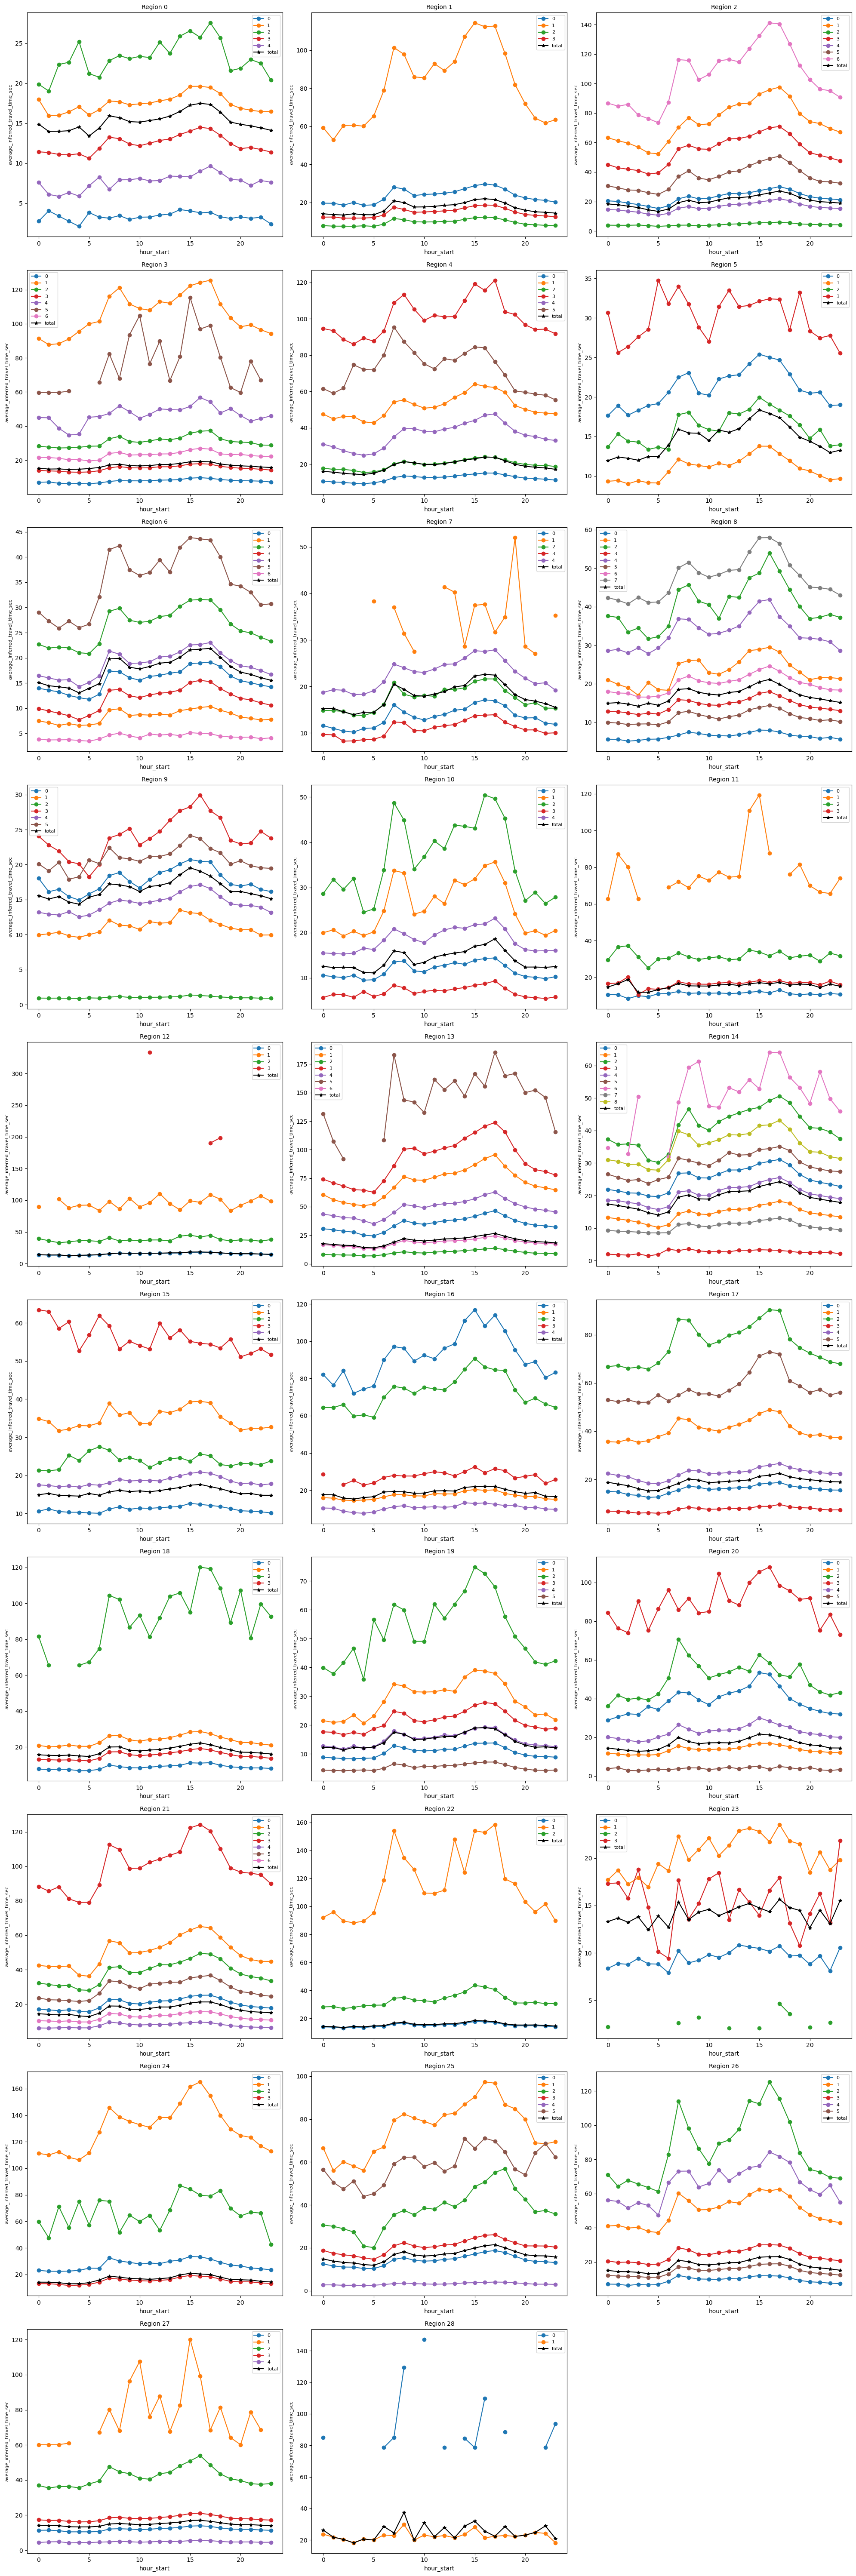

In [1448]:
fig, axs=plt.subplots(10, 3, figsize=(20,60))
for region in range(29):
    row_ind=region//3
    col_ind=region%3
    ax=axs[row_ind, col_ind]
    regions_c2_traveltime[f'region_{region}'].iloc[:,:-1].plot(marker='o', ax=ax)
    regions_c2_traveltime[f'region_{region}']['total'].plot(marker='*', color='black', label='total', ax=ax)
    ax.set_title(f'Region {region}', fontsize=10)
    ax.set_ylabel('average_inferred_travel_time_sec', fontsize=8)
    ax.legend(fontsize=8)
# Hide unused subplot
axs[9, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

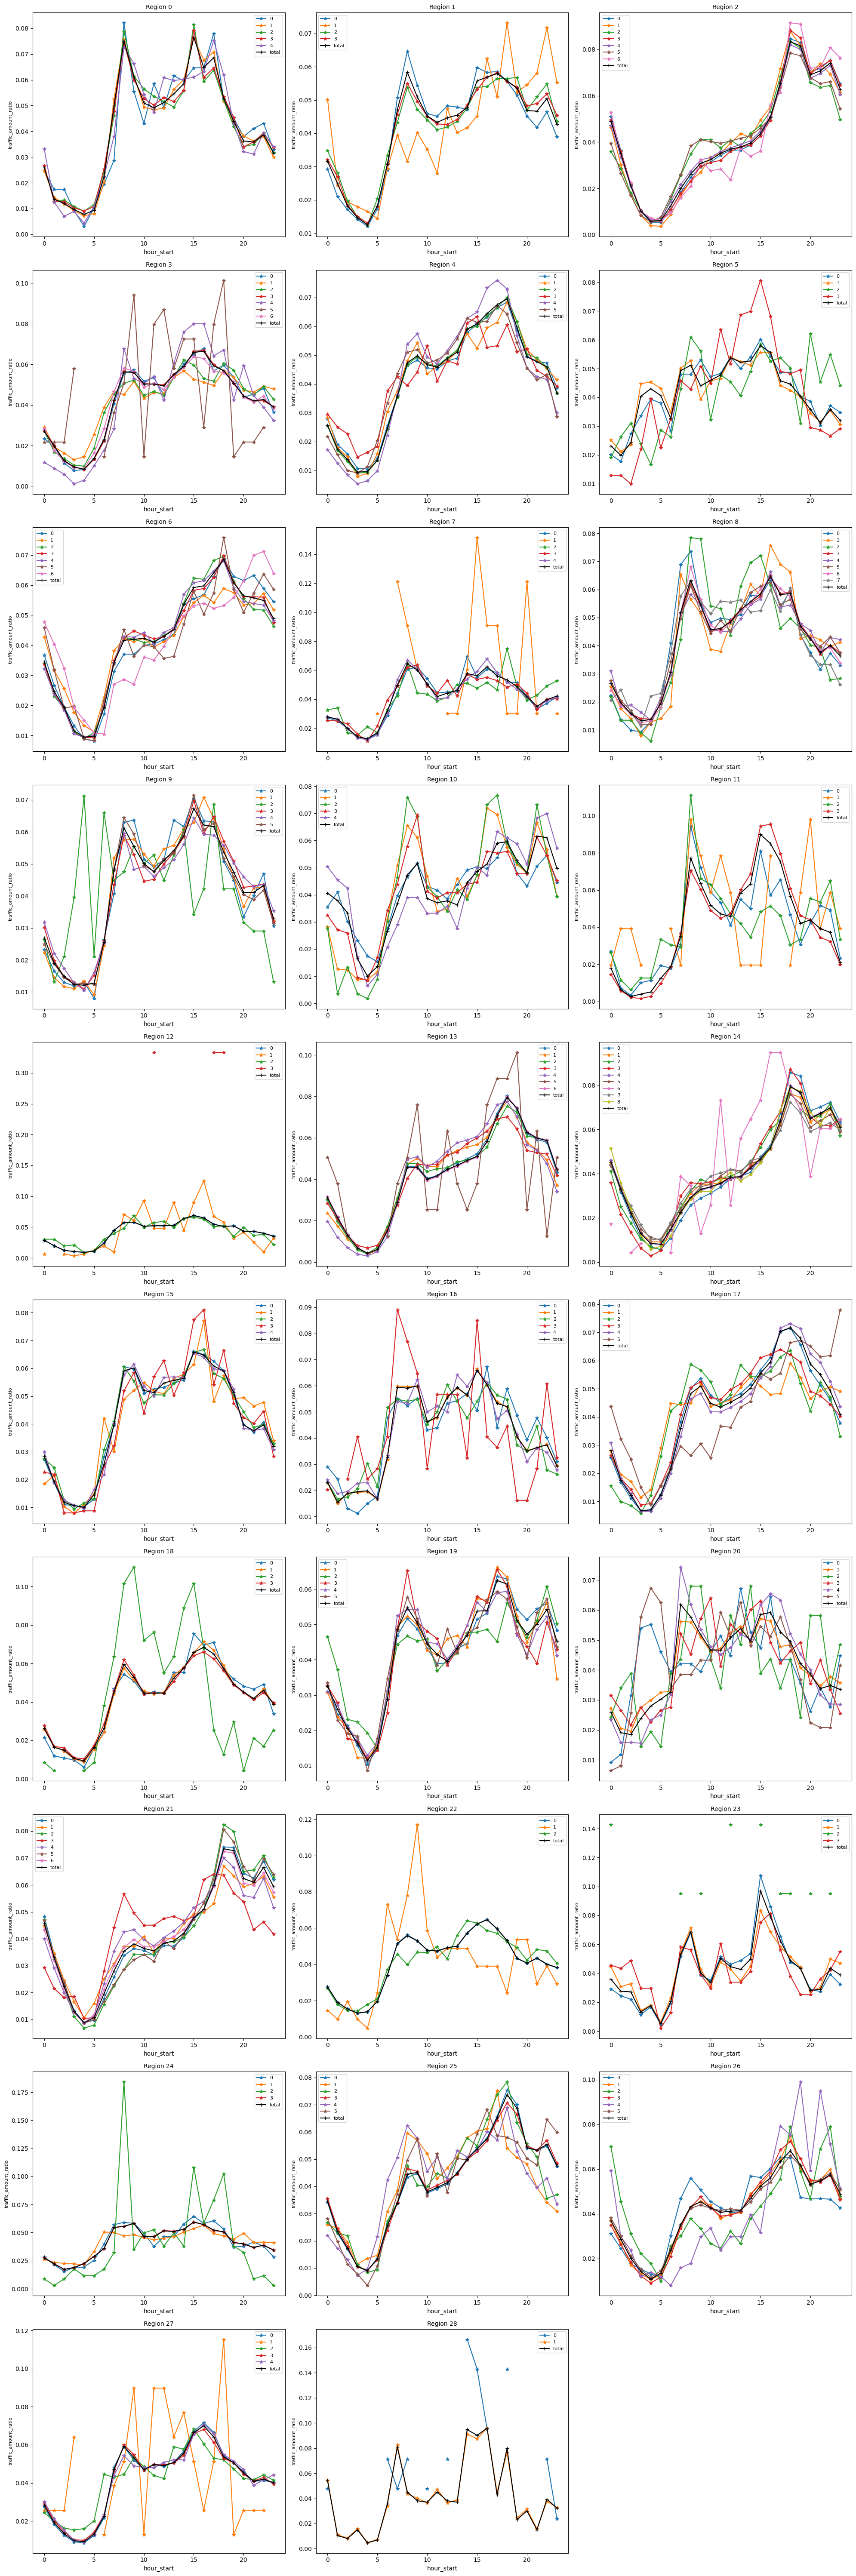

In [1449]:
fig, axs=plt.subplots(10, 3, figsize=(20,60))
for region in range(29):
    row_ind=region//3
    col_ind=region%3
    ax=axs[row_ind, col_ind]
    regions_c2_traffic[f'region_{region}'].iloc[:,:-1].plot(marker='*', ax=ax)
    regions_c2_traffic[f'region_{region}']['total'].plot(marker='+', color='black', label='total', ax=ax)
    ax.set_title(f'Region {region}', fontsize=10)
    ax.set_ylabel('traffic_amount_ratio', fontsize=8)
    ax.legend(fontsize=8)
# Hide unused subplot
axs[9, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

##### display the above results onto a map

In [193]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import TimeSliderChoropleth
import geopandas as gpd
import json
import networkx as nx

In [22]:
region=1
region_withcluster=pd.read_csv(f'region_{region}_withcluster.csv')
region_withcluster.head()

highway  speed_kph  lanes junction bridge tunnel access  travel_time  \
0    secondary       43.8    5.0       no     no     no    yes         16.7   
1    secondary       43.8    3.0       no     no     no    yes          8.3   
2    secondary       43.8    3.0       no     no     no    yes          8.5   
3    secondary       43.8    3.0       no     no     no    yes          8.3   
4  residential       31.9    2.0       no     no     no    yes         11.5   

   region          u  ...  prcp   wdir  wpgt    pres  year  month  dayname  \
0       1  256171157  ...   0.0  300.0   NaN  1009.0  2023      5  Tuesday   
1       1  256171159  ...   0.0  300.0   NaN  1009.0  2023      5  Tuesday   
2       1  261250154  ...   0.0  300.0   NaN  1009.0  2023      5  Tuesday   
3       1  261145124  ...   0.0  300.0   NaN  1009.0  2023      5  Tuesday   
4       1  261210232  ...   0.0  260.0   NaN  1015.5  2023      5  Tuesday   

   hour_start  hour_end  cluster  
0          19        20        0  
1          19        20        3  
2          19        20        3  
3          19        20        3  
4           9         9        0  

[5 rows x 28 columns]

In [1452]:
region_withcluster.columns

Index(['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel',
       'access', 'travel_time', 'region', 'u', 'v', 'inferred_travel_time_sec',
       'Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres', 'year', 'month',
       'dayname', 'hour_start', 'hour_end', 'cluster'],
      dtype='object')

In [252]:
region_data=region_withcluster.groupby(['cluster', 'u', 'v', 'hour_start'])[['inferred_travel_time_sec', 'travel_time']].mean()
region_data

inferred_travel_time_sec  \
cluster u           v         hour_start                             
0       35034227    838696277 0                          10.644275   
                              4                           9.428444   
                              6                          11.162727   
                              7                          15.685685   
                              8                          14.029567   
...                                                            ...   
3       12242626478 261264710 19                         15.379584   
                              20                         15.482742   
                              21                         15.669600   
                              22                         14.356501   
                              23                         12.282036   

                                          travel_time  
cluster u           v         hour_start               
0       35034227    838696277 0                   8.3  
                              4                   8.3  
                              6                   8.3  
                              7                   8.3  
                              8                   8.3  
...                                               ...  
3       12242626478 261264710 19                 10.5  
                              20                 10.5  
                              21                 10.5  
                              22                 10.5  
                              23                 10.5  

[40650 rows x 2 columns]

In [253]:
region_data['inferred_travel_time_sec'].isnull().sum()

0

In [265]:
# Add a congestion level column by comparing inferred_travel_time_sec with travel_time
def calculate_congestion_level(row):
    if pd.isna(row['inferred_travel_time_sec']):
        return ('green', 'free-flow')  # Mark NaN values as free flow
    ratio = row['inferred_travel_time_sec'] / row['travel_time']
    if ratio <= 1.2:
        return ('lightgreen', 'free_flow')  # Free flow
    elif ratio <= 1.5:
        return ('#FFDAB9', 'slight congestion')  # Slight congestion
    elif ratio <= 2.0:
        return ('orange', 'medium congestion')  # Medium congestion
    else:
        return ('red', 'heavy congestion')  # Heavy congestion
#application
region_data[['congestion_level', 'congestion_level_explanation']] = region_data.apply(lambda row: pd.Series(calculate_congestion_level(row)), axis=1)

In [255]:
m1=region_data.reset_index()
m2=region_withcluster.drop_duplicates(['u','v'])[['u', 'v', 'highway', 'lanes', 'junction', 'bridge', 'tunnel', 'access']]
merge=pd.merge(m1, m2, on=['u', 'v'])

In [256]:
region_data=merge.set_index(['cluster', 'u', 'v','hour_start'])

In [257]:
region_data.head()

inferred_travel_time_sec  travel_time  \
cluster u        v         hour_start                                          
0       35034227 838696277 0                          10.644275          8.3   
                           4                           9.428444          8.3   
                           6                          11.162727          8.3   
                           7                          15.685685          8.3   
                           8                          14.029567          8.3   

                                      congestion_level  \
cluster u        v         hour_start                    
0       35034227 838696277 0                    orange   
                           4                lightgreen   
                           6                    orange   
                           7                   #FF8C00   
                           8                   #FF8C00   

                                      congestion_level_explanation    highway  \
cluster u        v         hour_start                                           
0       35034227 838696277 0                     slight congestion  secondary   
                           4                             free_flow  secondary   
                           6                     slight congestion  secondary   
                           7                     medium congestion  secondary   
                           8                     medium congestion  secondary   

                                       lanes junction bridge tunnel access  
cluster u        v         hour_start                                       
0       35034227 838696277 0             4.5       no     no     no    yes  
                           4             4.5       no     no     no    yes  
                           6             4.5       no     no     no    yes  
                           7             4.5       no     no     no    yes  
                           8             4.5       no     no     no    yes

In [192]:
region_data.columns

Index(['inferred_travel_time_sec', 'travel_time', 'congestion_level',
       'congestion_level_explanation', 'highway', 'lanes', 'junction',
       'bridge', 'tunnel', 'access'],
      dtype='object')

In [266]:
# Define a function to plot road segments of a region with cluster and hour-based filtering
def plot_region_with_filters(region_data, region_id, G):
    # Initialize map centered on Chicago
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

    # Add a base layer with no visible data
    folium.TileLayer("cartodbdark_matter", name="No Data Visible", control=True).add_to(m)

    # Iterate through clusters and hours
    clusters = region_data.index.get_level_values("cluster").unique()

    for cluster in clusters:
        # Filter data for the current cluster 
        cluster_data = region_data[region_data.index.get_level_values("cluster") == cluster]
        for hour in range(24):  # Loop through hours from 0 to 23
            hour_data = cluster_data[cluster_data.index.get_level_values("hour_start") == hour]    
            # Prepare GeoJSON data
            geojson_data = {"type": "FeatureCollection", "features": []}

            for index, row in hour_data.iterrows():
                _, u, v,  hour_start = index
                    
                # Try to get the edge geometry
                edgs = G[u][v]
                if len(edgs) == 1:
                    edge_data = list(edgs.values())[0]
                else:
                    edge_data = min(edgs.values(), key=lambda x: x.get("length", float("inf")))

                # Extract coordinates from LineString
                line_coords = list(edge_data["geometry"].coords)

                # Add road segment as a GeoJSON feature
                feature = {
                        "type": "Feature",
                        "geometry": {
                            "type": "LineString",
                            "coordinates": line_coords
                        },
                        "properties": {
                            "congestion_level": row["congestion_level"],
                            "popup": (
                                f"Inferred Travel Time: {row['inferred_travel_time_sec']} sec<br>"
                                f"Free Flow Time: {row['travel_time']} sec<br>"
                                f"Congestion: {row['congestion_level_explanation']}<br>"
                                f"roadtype: {row['highway']}<br>"
                                f"lanes: {row['lanes']}<br>"
                                f"bridge: {row['bridge']}<br>"
                                f"tunnel: {row['tunnel']}<br>"
                                f"junction: {row['junction']}<br>"
                                f"access: {row['access']}<br>"
                            )
                        }
                    }
                geojson_data["features"].append(feature)

          
                # Add GeoJson layer for the specific cluster and hour, hidden by default
            folium.GeoJson(
                    geojson_data,
                    name=f"Cluster {cluster}  | Hour {hour}",  # Layer name for toggling
                    style_function=lambda feature: {
                            "color": feature["properties"]["congestion_level"],
                            "weight": 5,
                            "opacity": 1.0
                        },
                        popup=folium.GeoJsonPopup(
                            fields=["popup"],
                            aliases=["Info: "],
                            sticky=True,
                            max_width=400
                        ),
                        show=False  # Hide this layer by default
                    ).add_to(m)

    # Add layer control to toggle between combinations
    folium.LayerControl(collapsed=False).add_to(m)

    # Add title
    title_html = f"""
        <h3 align="center" style="font-size:16px"><b>Region {region_id} Traffic Congestion<br></h3>
        """
    m.get_root().html.add_child(folium.Element(title_html))

    return m


# Example usage
map_region = plot_region_with_filters(region_data=region_data, region_id=1, G=G)
map_region.save("region_1_traffic_filters_map.html")  # Save as an interactive HTML


##### compare the shortest route based on real traffic and free flow traffic data

In [216]:
region_data_hour=region_data[region_data.index.get_level_values('hour_start')==10]
region_data_hour

inferred_travel_time_sec  \
cluster u           v          hour_start                             
0       35034227    838696277  10                         11.928832   
                    838696685  10                         28.715249   
        35034233    1316564979 10                         41.622980   
        157719704   348167528  10                         27.328268   
                    440905576  10                         14.276503   
...                                                             ...   
3       7786136953  369630790  10                         14.631043   
                    7786136948 10                          5.024480   
        9159603376  369630919  10                         11.991301   
                    369630920  10                         36.440510   
        12242626478 261264710  10                         16.964657   

                                           travel_time congestion_level  \
cluster u           v          hour_start                                 
0       35034227    838696277  10                  8.3           orange   
                    838696685  10                 16.5            brown   
        35034233    1316564979 10                 23.0            brown   
        157719704   348167528  10                 16.7            brown   
                    440905576  10                  8.7            brown   
...                                                ...              ...   
3       7786136953  369630790  10                  8.3            brown   
                    7786136948 10                  3.0            brown   
        9159603376  369630919  10                  5.9              red   
                    369630920  10                 17.2              red   
        12242626478 261264710  10                 10.5            brown   

                                          congestion_level_explanation  \
cluster u           v          hour_start                                
0       35034227    838696277  10                    slight congestion   
                    838696685  10                    medium congestion   
        35034233    1316564979 10                    medium congestion   
        157719704   348167528  10                    medium congestion   
                    440905576  10                    medium congestion   
...                                                                ...   
3       7786136953  369630790  10                    medium congestion   
                    7786136948 10                    medium congestion   
        9159603376  369630919  10                     heavy congestion   
                    369630920  10                     heavy congestion   
        12242626478 261264710  10                    medium congestion   

                                               highway  lanes junction bridge  \
cluster u           v          hour_start                                       
0       35034227    838696277  10            secondary    4.5       no     no   
                    838696685  10            secondary    5.0       no     no   
        35034233    1316564979 10          residential    2.0       no     no   
        157719704   348167528  10            secondary    4.5       no     no   
                    440905576  10            secondary    4.5       no     no   
...                                                ...    ...      ...    ...   
3       7786136953  369630790  10            secondary    4.0       no     no   
                    7786136948 10            secondary    3.0       no     no   
        9159603376  369630919  10              primary    4.5       no     no   
                    369630920  10              primary    4.5       no     no   
        12242626478 261264710  10             tertiary    2.0       no     no   

                                          tunnel access  
cluster u           v          hour_start                
0       35

In [218]:
region_data_hour['inferred_travel_time_sec'].isnull().sum()

0

In [226]:
relevant_edges = [(row.name[1], row.name[2]) for _, row in region_data_hour.iterrows()]
relevant_nodes = set([node for edge in relevant_edges for node in edge])

# Handle multi-edge graph by selecting the shortest edge for each (u, v)
subset_edges = []
for u, v in relevant_edges:
    if G.has_edge(u, v):  
        # Find the edge with the minimum 'length' 
        min_edge_key = min(G[u][v], key=lambda k: G[u][v][k].get('length', float('inf')))
        subset_edges.append((u, v, min_edge_key))

# Create the subset graph with the selected edges
G_c = G.edge_subgraph(subset_edges).copy()

In [224]:
G_c[35034227][838696277][0]['inferred_travel_time_sec'] = row['inferred_travel_time_sec']

In [235]:
for _, row in region_data_hour.iterrows():
    u, v = row.name[1], row.name[2]
    edge_keys = list(G_c[u][v].keys())  # Get all keys for the edge
    if edge_keys:  # Ensure there are keys to access
        first_key = edge_keys[0]  # Get the first key
        G_c[u][v][first_key]['inferred_travel_time_sec'] = row['inferred_travel_time_sec']


In [267]:
#define a function to create a directed graph from the region_data dataframe.
def create_subset_graph_with_inferred_time(G, region_data_hour):
    # Extract relevant edges (u, v) from region_data_hour
    relevant_edges = [(row.name[1], row.name[2]) for _, row in region_data_hour.iterrows()]
    relevant_nodes = set([node for edge in relevant_edges for node in edge])

    # Handle multi-edge graph by selecting the shortest edge for each (u, v)
    subset_edges = []
    for u, v in relevant_edges:
        if G.has_edge(u, v):  
            # Find the edge with the minimum 'length' 
            min_edge_key = min(G[u][v], key=lambda k: G[u][v][k].get('length', float('inf')))
            subset_edges.append((u, v, min_edge_key))

    # Create the subset graph with the selected edges
    G_c = G.edge_subgraph(subset_edges).copy()

    # Add the inferred_travel_time_sec attribute from region_data_hour to the edges in G_c
    for _, row in region_data_hour.iterrows():
        u, v = row.name[1], row.name[2]
        edge_keys = list(G_c[u][v].keys())  
        first_key = edge_keys[0]  # Get the first key
        G_c[u][v][first_key]['inferred_travel_time_sec'] = row['inferred_travel_time_sec']
        G_c[u][v][first_key]['congestion_level_explanation'] = row['congestion_level_explanation']


    # Ensure all relevant nodes are included
    for node in relevant_nodes:
        if node not in G_c.nodes and node in G:
            G_c.add_node(node, **G.nodes[node])

    return G_c


# Example usage
G_c = create_subset_graph_with_inferred_time(G, region_data_hour)
print(f"Subset graph has {G_c.number_of_nodes()} nodes and {G_c.number_of_edges()} edges.")

# Example to inspect an edge's attributes
u, v, key = next(iter(G_c.edges))
print(f"Edge ({u}, {v}) attributes: {G_c[u][v][key]}")

Subset graph has 919 nodes and 1784 edges.
Edge (317749252, 317749771) attributes: {'osmid': 97519051, 'name': 'West Addison Street', 'highway': 'secondary', 'oneway': False, 'reversed': False, 'length': 56.115, 'speed_kph': 43.8, 'travel_time': 4.6, 'region': 1, 'geometry': <LINESTRING (-87.743 41.946, -87.742 41.946)>, 'area': nan, 'lanes': 3.0, 'access': 'yes', 'junction': 'no', 'bridge': 'no', 'tunnel': 'no', 'inferred_travel_time_sec': 7.364911546373882, 'congestion_level_explanation': 'medium congestion'}


In [268]:
# define a function to find a pair of nodes (start_node, end_node) in the graph with multiple routes between them
def find_pair_with_multiple_routes(region_data_hour, G_c):
    
    # Get unique list of nodes
    unique_nodes = list(set(G_c.nodes))  

    # Find a pair of nodes with multiple paths
    for i, start_node in enumerate(unique_nodes):
        for end_node in unique_nodes[i + 1:]:  # Check unique pairs (start_node, end_node)
            paths = list(nx.all_simple_paths(G_c, source=start_node, target=end_node, cutoff=5))  # Limit to 5 edges for simplicity
            if len(paths) > 1:  # Check if there are multiple paths
                return start_node, end_node
    # If no suitable pair is found, return None
    return None, None
# Example usage
start_node, end_node = find_pair_with_multiple_routes(region_data_hour, G_c)
if start_node and end_node:
    print(f"Found suitable nodes: Start Node = {start_node}, End Node = {end_node}")
else:
    print("No suitable nodes with multiple routes found.")


Found suitable nodes: Start Node = 261212166, End Node = 261145231


In [269]:
# define a function to calculate the shortest route in a graph based on a given weight
def calculate_shortest_route(G_c, start_node, end_node, weight):

    # Calculate the shortest path
    path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
    
    # Calculate the total weight of the path
    total_time = nx.shortest_path_length(G_c, source=start_node, target=end_node, weight=weight)
    
    return path, total_time


# Shortest route based on real traffic time
path_inferred, time_inferred = calculate_shortest_route(G_c, start_node, end_node, weight='inferred_travel_time_sec')
print(f"Shortest path (real traffic): {path_inferred}, Total time: {time_inferred} sec")

# Shortest route based on free-flow travel time
path_free_flow, time_free_flow = calculate_shortest_route(G_c, start_node, end_node, weight='travel_time')
print(f"Shortest path (free flow): {path_free_flow}, Total time: {time_free_flow} sec")

Shortest path (real traffic): [261212166, 261275109, 261123541, 261123542, 261123543, 261145231], Total time: 119.99996256211129 sec
Shortest path (free flow): [261212166, 261275109, 261123541, 261275234, 261227515, 261145231], Total time: 67.9 sec


In [270]:
# Define a function to display the calculated shortest routes on a map with detailed segment traffic info
def display_shortest_routes_with_details(region_data_hour, G_c, start_node, end_node):

    # Initialize map centered at the start node
    start_coords = (G_c.nodes[start_node]['y'], G_c.nodes[start_node]['x'])  # (latitude, longitude)
    m = folium.Map(location=start_coords, zoom_start=13)

    # Define weights and their visualization styles
    route_styles = {
        'inferred_travel_time_sec': {'color': 'red', 'dash_array': None},  # Solid red line
        'travel_time': {'color': 'green', 'dash_array': '5,10'},  # Dashed green line
    }

    for weight, style in route_styles.items():
        # Calculate shortest path and its nodes
        path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
        
        # Extract edges and their corresponding traffic information
        for u, v in zip(path[:-1], path[1:]):  # Iterate over consecutive nodes in the path
            edge_data = G_c[u][v]  # Access edge data
            edge_geometry = edge_data[0].get("geometry")  

            # Extract traffic information
            inferred_time = edge_data[0].get("inferred_travel_time_sec", "N/A")
            free_flow_time = edge_data[0].get("travel_time", "N/A")
            congestion_level=edge_data[0].get("congestion_level_explanation", "N/A")

            # Add the edge as a polyline to the map
            line_coords = list(edge_geometry.coords)
            line_coords_reversed = [[lat, lon] for lon, lat in line_coords]  # Reverse for folium
            folium.PolyLine(
                locations=line_coords_reversed,
                color=style['color'],
                weight=5,
                dash_array=style['dash_array'],  # Add dash style for travel_time route
                tooltip=f"<b>Route by {weight}</b><br>"
                        f"Start: {u}, End: {v}<br>"
                        f"Inferred Time: {inferred_time} sec<br>"
                        f"Free Flow Time: {free_flow_time} sec<br> "
                        f"Congestion_level: {congestion_level}"
            ).add_to(m)

    # Add markers for start and end nodes
    folium.Marker(location=start_coords, popup="Start Node", icon=folium.Icon(color="blue")).add_to(m)
    end_coords = (G_c.nodes[end_node]['y'], G_c.nodes[end_node]['x'])
    folium.Marker(location=end_coords, popup="End Node", icon=folium.Icon(color="blue")).add_to(m)

    return m


# Example usage
map_routes = display_shortest_routes_with_details(region_data_hour, G_c, start_node, end_node)
map_routes.save("shortest_routes_with_details_map.html")  # Save as an interactive HTML
